http://gluon.mxnet.io/chapter14_generative-adversarial-networks/pixel2pixel.html

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://affinelayer.com/pixsrv/

https://phillipi.github.io/pix2pix/

#### GAN 
##### G:z→y

\begin{equation*}
\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))] \hspace{15pt}  (1)
\end{equation*}

#### Conditional GAN
##### G:{x,z} →y

- x = real_in
- y = real_out 
- G(x,z) = fake_out

\begin{equation*}
\min_G \max_D V(D,G) = \mathbb{E}_{x,y\sim p_{data}~(x,y)}[log D(x,y)] + \mathbb{E}_{x\sim p_{data}, z\sim p_z(x)}[log(1-D(x, G(x,z)))] \hspace{15pt}  (2)
\end{equation*}

\begin{equation*}
G
∗
= arg \min_G  (1-D(x, G(x, z)) + lambda1 * L1(y, G(x, z))
\end{equation*}

![title](images/cgan.png)

![title](images/unet_.png)

In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet.gluon.nn import Dense, Activation, Conv2D, Conv2DTranspose, \
    BatchNorm, LeakyReLU, Flatten, HybridSequential, HybridBlock, Dropout
from mxnet import autograd
import numpy as np

/home/hyungjunkim/python/venv/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
epochs = 100
batch_size = 10

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5
lambda1 = 100

pool_size = 50

In [3]:
img_wd = 256
img_ht = 256

In [4]:
def load_data(dir_path, batch_size, is_reversed=False):
    import os
    img_in_list = []
    img_out_list = []
    for path in os.listdir(dir_path):
        path = os.path.join(dir_path, path)
        for path, _, fnames in os.walk(path):
            for fname in fnames:
                if not fname.endswith('.ppm'):
                    continue
                img = os.path.join(path, fname)
                img_arr = mx.image.imread(img).astype(np.float32)/127.5 - 1
                img_arr = mx.image.imresize(img_arr, img_wd * 2, img_ht)
                # Crop input and output images
                img_arr_in, img_arr_out = [mx.image.fixed_crop(img_arr, 0, 0, img_wd, img_ht),
                                           mx.image.fixed_crop(img_arr, img_wd, 0, img_wd, img_ht)]
                img_arr_in, img_arr_out = [nd.transpose(img_arr_in, (2,0,1)),
                                           nd.transpose(img_arr_out, (2,0,1))]
                img_arr_in, img_arr_out = [img_arr_in.reshape((1,) + img_arr_in.shape),
                                           img_arr_out.reshape((1,) + img_arr_out.shape)]
                img_in_list.append(img_arr_out if is_reversed else img_arr_in)
                img_out_list.append(img_arr_in if is_reversed else img_arr_out)

    return mx.io.NDArrayIter(data=[nd.concat(*img_in_list, dim=0), nd.concat(*img_out_list, dim=0)], batch_size=batch_size)

In [5]:
train_img_path = '/home/hyungjunkim/repo/db/traffic/datasets/BelgiumTS_T/Training/'
val_img_path = '/home/hyungjunkim/repo/db/traffic/datasets/BelgiumTS_T/Testing/'

In [6]:
train_data = load_data(train_img_path, batch_size, is_reversed=True)
val_data = load_data(val_img_path, batch_size, is_reversed=True)

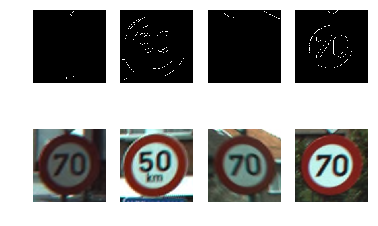

In [7]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

def preview_train_data():
    img_in_list, img_out_list = train_data.next().data
    for i in range(4):
        plt.subplot(2,4,i+1)
        visualize(img_in_list[i])
        plt.subplot(2,4,i+5)
        visualize(img_out_list[i])
    plt.show()

preview_train_data()

In [8]:
# Define Unet generator skip block
class UnetSkipUnit(HybridBlock):
    def __init__(self, inner_channels, outer_channels, inner_block=None, innermost=False, outermost=False,
                 use_dropout=False, use_bias=False):
        super(UnetSkipUnit, self).__init__()

        with self.name_scope():
            self.outermost = outermost
            en_conv = Conv2D(channels=inner_channels, kernel_size=4, strides=2, padding=1,
                             in_channels=outer_channels, use_bias=use_bias)
            en_relu = LeakyReLU(alpha=0.2)
            en_norm = BatchNorm(momentum=0.1, in_channels=inner_channels)
            de_relu = Activation(activation='relu')
            de_norm = BatchNorm(momentum=0.1, in_channels=outer_channels)

            if innermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels, use_bias=use_bias)
                encoder = [en_relu, en_conv]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + decoder
            elif outermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2)
                encoder = [en_conv]
                decoder = [de_relu, de_conv, Activation(activation='tanh')]
                model = encoder + [inner_block] + decoder
            else:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2, use_bias=use_bias)
                encoder = [en_relu, en_conv, en_norm]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + [inner_block] + decoder
            if use_dropout:
                model += [Dropout(rate=0.5)]

            self.model = HybridSequential()
            with self.model.name_scope():
                for block in model:
                    self.model.add(block)

    def hybrid_forward(self, F, x):
        if self.outermost:
            return self.model(x)
        else:
            return F.concat(self.model(x), x, dim=1)

# Define Unet generator
class UnetGenerator(HybridBlock):
    def __init__(self, in_channels, num_downs, ngf=64, use_dropout=True):
        super(UnetGenerator, self).__init__()

        #Build unet generator structure
        unet = UnetSkipUnit(ngf * 8, ngf * 8, innermost=True)
        for _ in range(num_downs - 5):
            unet = UnetSkipUnit(ngf * 8, ngf * 8, unet, use_dropout=use_dropout)
        unet = UnetSkipUnit(ngf * 8, ngf * 4, unet)
        unet = UnetSkipUnit(ngf * 4, ngf * 2, unet)
        unet = UnetSkipUnit(ngf * 2, ngf * 1, unet)
        unet = UnetSkipUnit(ngf, in_channels, unet, outermost=True)

        with self.name_scope():
            self.model = unet

    def hybrid_forward(self, F, x):
        return self.model(x)

# Define the PatchGAN discriminator
class Discriminator(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_sigmoid=False, use_bias=False):
        super(Discriminator, self).__init__()

        with self.name_scope():
            self.model = HybridSequential()
            kernel_size = 4
            padding = int(np.ceil((kernel_size - 1)/2))
            self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=in_channels))
            self.model.add(LeakyReLU(alpha=0.2))

            nf_mult = 1
            for n in range(1, n_layers):
                nf_mult_prev = nf_mult
                nf_mult = min(2 ** n, 8)
                self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                      padding=padding, in_channels=ndf * nf_mult_prev,
                                      use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
                self.model.add(LeakyReLU(alpha=0.2))

            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n_layers, 8)
            self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult_prev,
                                  use_bias=use_bias))
            self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
            self.model.add(LeakyReLU(alpha=0.2))
            self.model.add(Conv2D(channels=1, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult))
            if use_sigmoid:
                self.model.add(Activation(activation='sigmoid'))

    def hybrid_forward(self, F, x):
        out = self.model(x)
        #print(out)
        return out

In [9]:
def param_init(param):
    if param.name.find('conv') != -1:
        if param.name.find('weight') != -1:
            param.initialize(init=mx.init.Normal(0.02), ctx=ctx)
        else:
            param.initialize(init=mx.init.Zero(), ctx=ctx)
    elif param.name.find('batchnorm') != -1:
        param.initialize(init=mx.init.Zero(), ctx=ctx)
        # Initialize gamma from normal distribution with mean 1 and std 0.02
        if param.name.find('gamma') != -1:
            param.set_data(nd.random_normal(1, 0.02, param.data().shape))

def network_init(net):
    for param in net.collect_params().values():
        param_init(param)

def set_network():
    # Pixel2pixel networks
    netG = UnetGenerator(in_channels=3, num_downs=8)
    netD = Discriminator(in_channels=6)

    # Initialize parameters
    network_init(netG)
    network_init(netD)

    # trainer for the generator and the discriminator
    trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

    return netG, netD, trainerG, trainerD

# Loss
GAN_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
L1_loss = gluon.loss.L1Loss()

netG, netD, trainerG, trainerD = set_network()

In [12]:
print(netD)

Discriminator(
  (model): HybridSequential(
    (0): Conv2D(6 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(0.2)
    (2): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=128)
    (4): LeakyReLU(0.2)
    (5): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (6): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=256)
    (7): LeakyReLU(0.2)
    (8): Conv2D(256 -> 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (9): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=512)
    (10): LeakyReLU(0.2)
    (11): Conv2D(512 -> 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)


In [13]:
print(netG)

UnetGenerator(
  (model): UnetSkipUnit(
    (model): HybridSequential(
      (0): Conv2D(3 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipUnit(
        (model): HybridSequential(
          (0): LeakyReLU(0.2)
          (1): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=128)
          (3): UnetSkipUnit(
            (model): HybridSequential(
              (0): LeakyReLU(0.2)
              (1): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=256)
              (3): UnetSkipUnit(
                (model): HybridSequential(
                  (0): LeakyReLU(0.2)
                  (1): Conv2D(256 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [20]:
sym_data = mx.sym.Variable('data')
net = netG(sym_data)

In [22]:
viz = mx.viz.plot_network(net,title='unet', save_format='png', shape={'data':(1,3,256,256)})
viz.render('images/unet')

'images/unet.png'

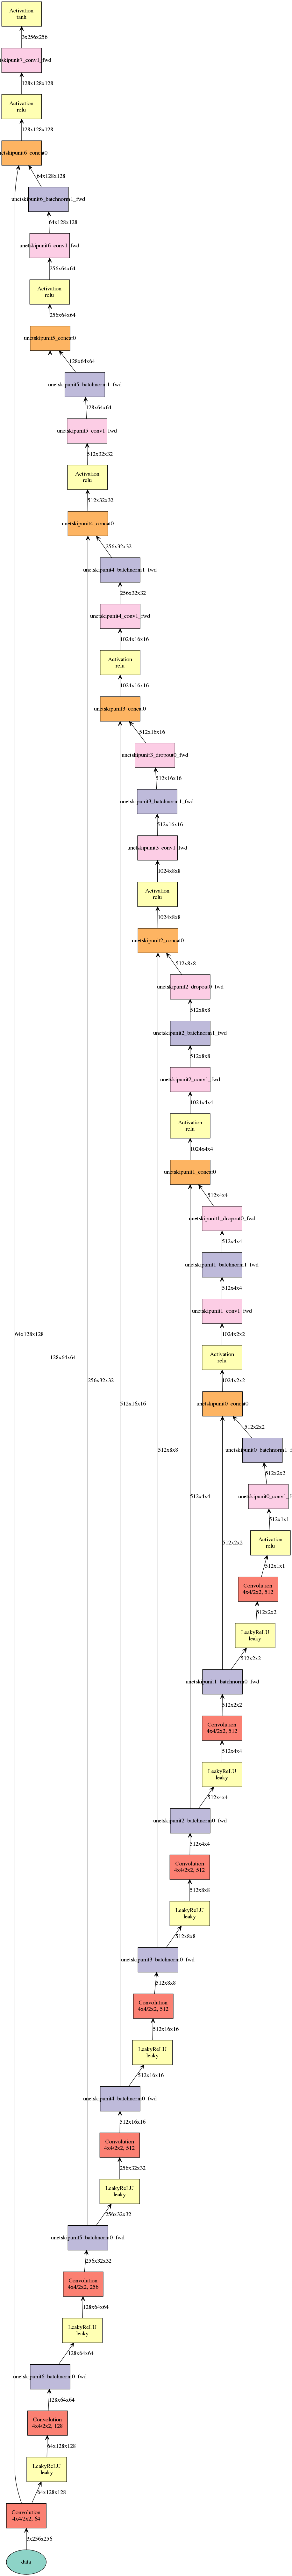

In [23]:
from IPython.display import Image
Image("images/unet.png")

In [10]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        ret_imgs = []
        for i in range(images.shape[0]):
            image = nd.expand_dims(images[i], axis=0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                ret_imgs.append(image)
            else:
                p = nd.random_uniform(0, 1, shape=(1,)).asscalar()
                if p > 0.5:
                    random_id = nd.random_uniform(0, self.pool_size - 1, shape=(1,)).astype(np.uint8).asscalar()
                    tmp = self.images[random_id].copy()
                    self.images[random_id] = image
                    ret_imgs.append(tmp)
                else:
                    ret_imgs.append(image)
        ret_imgs = nd.concat(*ret_imgs, dim=0)
        return ret_imgs

INFO:root:speed: 51.12056094472335 samples/s
INFO:root:discriminator loss = 0.562742, generator loss = 28.949280, binary training acc = 0.752327 at iter 0 epoch 0
INFO:root:speed: 29.722089550969617 samples/s
INFO:root:discriminator loss = 0.978490, generator loss = 24.060865, binary training acc = 0.700308 at iter 10 epoch 0
INFO:root:speed: 29.364535616796083 samples/s
INFO:root:discriminator loss = 0.315750, generator loss = 24.567654, binary training acc = 0.719625 at iter 20 epoch 0
INFO:root:speed: 29.855672451347466 samples/s
INFO:root:discriminator loss = 0.360761, generator loss = 24.472898, binary training acc = 0.763052 at iter 30 epoch 0
INFO:root:speed: 28.90721552854191 samples/s
INFO:root:discriminator loss = 0.600538, generator loss = 21.528210, binary training acc = 0.738770 at iter 40 epoch 0
INFO:root:speed: 29.579409032984223 samples/s
INFO:root:discriminator loss = 0.415223, generator loss = 21.309668, binary training acc = 0.753381 at iter 50 epoch 0
INFO:root:spe

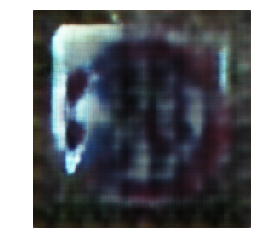

INFO:root:speed: 61.81611848262303 samples/s
INFO:root:discriminator loss = 0.588639, generator loss = 23.393791, binary training acc = 0.522898 at iter 0 epoch 1
INFO:root:speed: 29.10752417296972 samples/s
INFO:root:discriminator loss = 0.276223, generator loss = 22.781879, binary training acc = 0.763811 at iter 10 epoch 1
INFO:root:speed: 29.572047204678164 samples/s
INFO:root:discriminator loss = 0.344108, generator loss = 23.784996, binary training acc = 0.839736 at iter 20 epoch 1
INFO:root:speed: 29.143018341956097 samples/s
INFO:root:discriminator loss = 0.549690, generator loss = 23.662952, binary training acc = 0.824944 at iter 30 epoch 1
INFO:root:speed: 28.990353146580055 samples/s
INFO:root:discriminator loss = 0.577978, generator loss = 22.711884, binary training acc = 0.785031 at iter 40 epoch 1
INFO:root:speed: 29.641493953050542 samples/s
INFO:root:discriminator loss = 0.541005, generator loss = 20.666693, binary training acc = 0.782583 at iter 50 epoch 1
INFO:root:spe

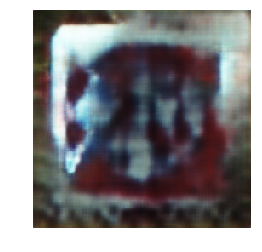

INFO:root:speed: 61.51494129811465 samples/s
INFO:root:discriminator loss = 0.250228, generator loss = 21.472406, binary training acc = 0.822000 at iter 0 epoch 2
INFO:root:speed: 28.93980625396738 samples/s
INFO:root:discriminator loss = 0.470582, generator loss = 22.493258, binary training acc = 0.877154 at iter 10 epoch 2
INFO:root:speed: 28.907833151724798 samples/s
INFO:root:discriminator loss = 0.410611, generator loss = 24.134808, binary training acc = 0.865145 at iter 20 epoch 2
INFO:root:speed: 29.213982132981545 samples/s
INFO:root:discriminator loss = 0.524228, generator loss = 23.079466, binary training acc = 0.836211 at iter 30 epoch 2
INFO:root:speed: 29.315565409021747 samples/s
INFO:root:discriminator loss = 0.614223, generator loss = 20.992151, binary training acc = 0.783797 at iter 40 epoch 2
INFO:root:speed: 29.522195999377786 samples/s
INFO:root:discriminator loss = 0.310461, generator loss = 20.532909, binary training acc = 0.795711 at iter 50 epoch 2
INFO:root:spe

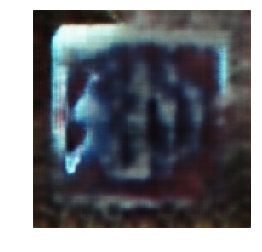

INFO:root:speed: 61.147697286895166 samples/s
INFO:root:discriminator loss = 0.400633, generator loss = 21.713425, binary training acc = 0.692122 at iter 0 epoch 3
INFO:root:speed: 28.855607894883487 samples/s
INFO:root:discriminator loss = 0.596282, generator loss = 22.232986, binary training acc = 0.769343 at iter 10 epoch 3
INFO:root:speed: 29.143200586434872 samples/s
INFO:root:discriminator loss = 0.437705, generator loss = 23.752079, binary training acc = 0.827316 at iter 20 epoch 3
INFO:root:speed: 29.140386175924586 samples/s
INFO:root:discriminator loss = 0.498663, generator loss = 21.894665, binary training acc = 0.800487 at iter 30 epoch 3
INFO:root:speed: 28.96294751554039 samples/s
INFO:root:discriminator loss = 0.599480, generator loss = 19.410053, binary training acc = 0.757229 at iter 40 epoch 3
INFO:root:speed: 29.555397556113487 samples/s
INFO:root:discriminator loss = 0.558395, generator loss = 19.326483, binary training acc = 0.766226 at iter 50 epoch 3
INFO:root:sp

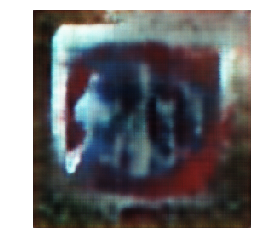

INFO:root:speed: 55.111706775463006 samples/s
INFO:root:discriminator loss = 0.580697, generator loss = 20.450464, binary training acc = 0.618122 at iter 0 epoch 4
INFO:root:speed: 29.237339943439537 samples/s
INFO:root:discriminator loss = 0.161079, generator loss = 20.920689, binary training acc = 0.830427 at iter 10 epoch 4
INFO:root:speed: 28.76852345315234 samples/s
INFO:root:discriminator loss = 0.105554, generator loss = 22.009939, binary training acc = 0.804818 at iter 20 epoch 4
INFO:root:speed: 28.90108057676698 samples/s
INFO:root:discriminator loss = 0.498087, generator loss = 21.655443, binary training acc = 0.809475 at iter 30 epoch 4
INFO:root:speed: 29.122398945170676 samples/s
INFO:root:discriminator loss = 0.638377, generator loss = 19.180859, binary training acc = 0.758374 at iter 40 epoch 4
INFO:root:speed: 28.790008106470005 samples/s
INFO:root:discriminator loss = 0.496454, generator loss = 18.539047, binary training acc = 0.763504 at iter 50 epoch 4
INFO:root:spe

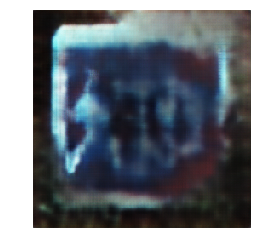

INFO:root:speed: 56.136774283351045 samples/s
INFO:root:discriminator loss = 0.304956, generator loss = 20.069569, binary training acc = 0.744898 at iter 0 epoch 5
INFO:root:speed: 28.879588967336893 samples/s
INFO:root:discriminator loss = 0.273177, generator loss = 20.748444, binary training acc = 0.846174 at iter 10 epoch 5
INFO:root:speed: 28.89785479639306 samples/s
INFO:root:discriminator loss = 0.229450, generator loss = 22.095768, binary training acc = 0.865788 at iter 20 epoch 5
INFO:root:speed: 29.000876739304196 samples/s
INFO:root:discriminator loss = 0.340561, generator loss = 21.142824, binary training acc = 0.818362 at iter 30 epoch 5
INFO:root:speed: 29.08467576126776 samples/s
INFO:root:discriminator loss = 0.478351, generator loss = 18.220959, binary training acc = 0.758370 at iter 40 epoch 5
INFO:root:speed: 29.25908176113791 samples/s
INFO:root:discriminator loss = 0.290389, generator loss = 18.204824, binary training acc = 0.772523 at iter 50 epoch 5
INFO:root:spee

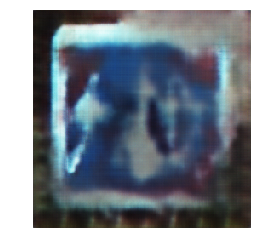

INFO:root:speed: 58.195218736558765 samples/s
INFO:root:discriminator loss = 0.244074, generator loss = 18.830120, binary training acc = 0.926408 at iter 0 epoch 6
INFO:root:speed: 29.67563639862656 samples/s
INFO:root:discriminator loss = 0.240406, generator loss = 20.219248, binary training acc = 0.838657 at iter 10 epoch 6
INFO:root:speed: 29.347605376785726 samples/s
INFO:root:discriminator loss = 0.879566, generator loss = 22.525490, binary training acc = 0.855658 at iter 20 epoch 6
INFO:root:speed: 29.351897727877102 samples/s
INFO:root:discriminator loss = 0.382024, generator loss = 20.776114, binary training acc = 0.814244 at iter 30 epoch 6
INFO:root:speed: 29.39660036206922 samples/s
INFO:root:discriminator loss = 0.588929, generator loss = 18.116512, binary training acc = 0.771331 at iter 40 epoch 6
INFO:root:speed: 29.18572577704668 samples/s
INFO:root:discriminator loss = 0.331478, generator loss = 18.225409, binary training acc = 0.778144 at iter 50 epoch 6
INFO:root:spee

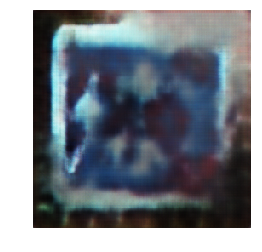

INFO:root:speed: 58.74778521215041 samples/s
INFO:root:discriminator loss = 0.735043, generator loss = 17.936129, binary training acc = 0.528000 at iter 0 epoch 7
INFO:root:speed: 29.345552064289667 samples/s
INFO:root:discriminator loss = 0.634298, generator loss = 20.266460, binary training acc = 0.715755 at iter 10 epoch 7
INFO:root:speed: 28.836007609294228 samples/s
INFO:root:discriminator loss = 0.184944, generator loss = 21.574347, binary training acc = 0.776672 at iter 20 epoch 7
INFO:root:speed: 29.207736634111523 samples/s
INFO:root:discriminator loss = 0.454035, generator loss = 20.640768, binary training acc = 0.762205 at iter 30 epoch 7
INFO:root:speed: 28.83321257350424 samples/s
INFO:root:discriminator loss = 0.708809, generator loss = 17.964333, binary training acc = 0.721659 at iter 40 epoch 7
INFO:root:speed: 28.835214636282576 samples/s
INFO:root:discriminator loss = 0.406340, generator loss = 17.867558, binary training acc = 0.738018 at iter 50 epoch 7
INFO:root:spe

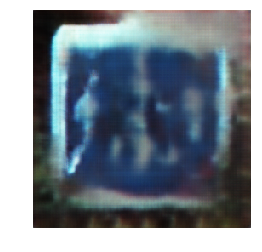

INFO:root:speed: 60.205118930223676 samples/s
INFO:root:discriminator loss = 0.359797, generator loss = 17.576742, binary training acc = 0.722694 at iter 0 epoch 8
INFO:root:speed: 28.818374264047595 samples/s
INFO:root:discriminator loss = 0.385399, generator loss = 20.311459, binary training acc = 0.757955 at iter 10 epoch 8
INFO:root:speed: 29.225666553321478 samples/s
INFO:root:discriminator loss = 0.311845, generator loss = 20.824726, binary training acc = 0.764375 at iter 20 epoch 8
INFO:root:speed: 28.73675029683583 samples/s
INFO:root:discriminator loss = 0.998884, generator loss = 21.481394, binary training acc = 0.727501 at iter 30 epoch 8
INFO:root:speed: 29.12555370303116 samples/s
INFO:root:discriminator loss = 0.630470, generator loss = 17.502506, binary training acc = 0.705577 at iter 40 epoch 8
INFO:root:speed: 29.00149837129046 samples/s
INFO:root:discriminator loss = 0.199395, generator loss = 17.156914, binary training acc = 0.722944 at iter 50 epoch 8
INFO:root:spee

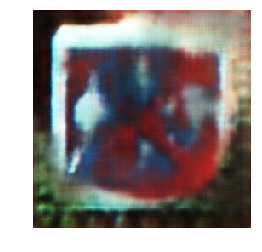

INFO:root:speed: 59.271133771499066 samples/s
INFO:root:discriminator loss = 0.314435, generator loss = 17.513861, binary training acc = 0.865429 at iter 0 epoch 9
INFO:root:speed: 28.946916555552797 samples/s
INFO:root:discriminator loss = 0.097230, generator loss = 18.860172, binary training acc = 0.875581 at iter 10 epoch 9
INFO:root:speed: 29.454257917452594 samples/s
INFO:root:discriminator loss = 0.314220, generator loss = 19.667313, binary training acc = 0.836175 at iter 20 epoch 9
INFO:root:speed: 29.12986226476945 samples/s
INFO:root:discriminator loss = 0.391733, generator loss = 20.354267, binary training acc = 0.835554 at iter 30 epoch 9
INFO:root:speed: 28.929606278248983 samples/s
INFO:root:discriminator loss = 0.669641, generator loss = 17.156912, binary training acc = 0.800056 at iter 40 epoch 9
INFO:root:speed: 29.091696011730164 samples/s
INFO:root:discriminator loss = 0.288174, generator loss = 16.951387, binary training acc = 0.805132 at iter 50 epoch 9
INFO:root:sp

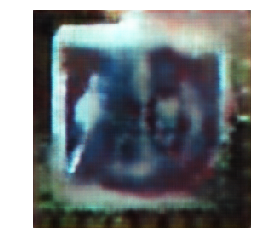

INFO:root:speed: 55.51759054707468 samples/s
INFO:root:discriminator loss = 0.566060, generator loss = 17.164480, binary training acc = 0.592653 at iter 0 epoch 10
INFO:root:speed: 29.41319528693669 samples/s
INFO:root:discriminator loss = 0.400304, generator loss = 19.081869, binary training acc = 0.785328 at iter 10 epoch 10
INFO:root:speed: 29.16804765577244 samples/s
INFO:root:discriminator loss = 0.485912, generator loss = 20.659243, binary training acc = 0.800985 at iter 20 epoch 10
INFO:root:speed: 28.89357477995562 samples/s
INFO:root:discriminator loss = 0.617190, generator loss = 20.522383, binary training acc = 0.750951 at iter 30 epoch 10
INFO:root:speed: 29.5456540253212 samples/s
INFO:root:discriminator loss = 0.694353, generator loss = 16.286215, binary training acc = 0.729288 at iter 40 epoch 10
INFO:root:speed: 28.891584506581417 samples/s
INFO:root:discriminator loss = 0.253768, generator loss = 16.718899, binary training acc = 0.737244 at iter 50 epoch 10
INFO:root:s

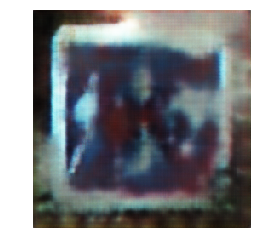

INFO:root:speed: 60.676653333429776 samples/s
INFO:root:discriminator loss = 0.433625, generator loss = 18.037601, binary training acc = 0.844531 at iter 0 epoch 11
INFO:root:speed: 28.813662484156726 samples/s
INFO:root:discriminator loss = 0.220091, generator loss = 18.530033, binary training acc = 0.775644 at iter 10 epoch 11
INFO:root:speed: 29.18885364458431 samples/s
INFO:root:discriminator loss = 0.362933, generator loss = 19.933142, binary training acc = 0.811763 at iter 20 epoch 11
INFO:root:speed: 28.686396424924578 samples/s
INFO:root:discriminator loss = 0.739091, generator loss = 20.564507, binary training acc = 0.774494 at iter 30 epoch 11
INFO:root:speed: 29.161902881354283 samples/s
INFO:root:discriminator loss = 1.107356, generator loss = 16.596851, binary training acc = 0.732742 at iter 40 epoch 11
INFO:root:speed: 28.78141434547271 samples/s
INFO:root:discriminator loss = 0.326967, generator loss = 16.743633, binary training acc = 0.750945 at iter 50 epoch 11
INFO:ro

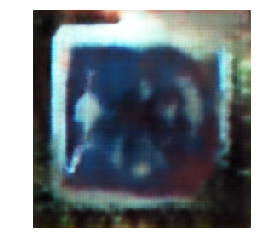

INFO:root:speed: 57.07110647874752 samples/s
INFO:root:discriminator loss = 0.382120, generator loss = 17.271013, binary training acc = 0.843796 at iter 0 epoch 12
INFO:root:speed: 29.194298545402404 samples/s
INFO:root:discriminator loss = 0.398278, generator loss = 19.679003, binary training acc = 0.820709 at iter 10 epoch 12
INFO:root:speed: 29.03671417386013 samples/s
INFO:root:discriminator loss = 0.319859, generator loss = 19.205627, binary training acc = 0.821213 at iter 20 epoch 12
INFO:root:speed: 29.307617541650625 samples/s
INFO:root:discriminator loss = 0.397718, generator loss = 20.466730, binary training acc = 0.773101 at iter 30 epoch 12
INFO:root:speed: 29.20133116114569 samples/s
INFO:root:discriminator loss = 0.586658, generator loss = 15.519371, binary training acc = 0.749485 at iter 40 epoch 12
INFO:root:speed: 29.11534365971531 samples/s
INFO:root:discriminator loss = 0.369398, generator loss = 17.089701, binary training acc = 0.756367 at iter 50 epoch 12
INFO:root

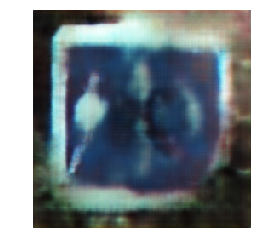

INFO:root:speed: 60.60791371584549 samples/s
INFO:root:discriminator loss = 0.398897, generator loss = 16.359119, binary training acc = 0.904816 at iter 0 epoch 13
INFO:root:speed: 29.075542406038178 samples/s
INFO:root:discriminator loss = 0.207950, generator loss = 18.783100, binary training acc = 0.819889 at iter 10 epoch 13
INFO:root:speed: 29.18454792278693 samples/s
INFO:root:discriminator loss = 0.515168, generator loss = 18.696875, binary training acc = 0.803545 at iter 20 epoch 13
INFO:root:speed: 29.333074105752264 samples/s
INFO:root:discriminator loss = 0.656958, generator loss = 19.487862, binary training acc = 0.761693 at iter 30 epoch 13
INFO:root:speed: 29.097669927025226 samples/s
INFO:root:discriminator loss = 0.751275, generator loss = 15.788200, binary training acc = 0.706806 at iter 40 epoch 13
INFO:root:speed: 29.172165900668812 samples/s
INFO:root:discriminator loss = 0.298234, generator loss = 17.414673, binary training acc = 0.723988 at iter 50 epoch 13
INFO:ro

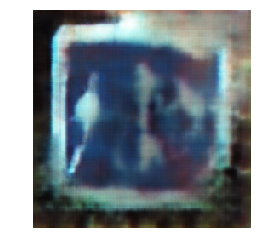

INFO:root:speed: 60.69105226373951 samples/s
INFO:root:discriminator loss = 0.300624, generator loss = 15.052315, binary training acc = 0.882041 at iter 0 epoch 14
INFO:root:speed: 29.23872588624771 samples/s
INFO:root:discriminator loss = 0.251422, generator loss = 17.486818, binary training acc = 0.790605 at iter 10 epoch 14
INFO:root:speed: 29.381300164898825 samples/s
INFO:root:discriminator loss = 0.224738, generator loss = 18.160995, binary training acc = 0.826270 at iter 20 epoch 14
INFO:root:speed: 28.331641258525387 samples/s
INFO:root:discriminator loss = 0.716620, generator loss = 20.637892, binary training acc = 0.799036 at iter 30 epoch 14
INFO:root:speed: 29.163890016854587 samples/s
INFO:root:discriminator loss = 0.696299, generator loss = 15.883600, binary training acc = 0.763628 at iter 40 epoch 14
INFO:root:speed: 29.62325956541576 samples/s
INFO:root:discriminator loss = 0.268588, generator loss = 15.838429, binary training acc = 0.762132 at iter 50 epoch 14
INFO:roo

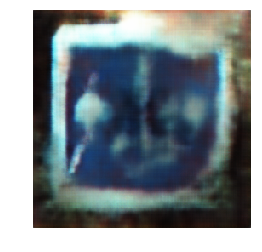

INFO:root:speed: 56.28593436735921 samples/s
INFO:root:discriminator loss = 0.305008, generator loss = 15.182871, binary training acc = 0.811755 at iter 0 epoch 15
INFO:root:speed: 29.230473312574745 samples/s
INFO:root:discriminator loss = 0.579319, generator loss = 17.510307, binary training acc = 0.851659 at iter 10 epoch 15
INFO:root:speed: 29.2318586044437 samples/s
INFO:root:discriminator loss = 0.521861, generator loss = 19.018398, binary training acc = 0.828741 at iter 20 epoch 15
INFO:root:speed: 28.947256179832664 samples/s
INFO:root:discriminator loss = 0.654305, generator loss = 19.213917, binary training acc = 0.780512 at iter 30 epoch 15
INFO:root:speed: 28.782619138299587 samples/s
INFO:root:discriminator loss = 0.720204, generator loss = 15.527011, binary training acc = 0.757311 at iter 40 epoch 15
INFO:root:speed: 28.74586902319104 samples/s
INFO:root:discriminator loss = 0.303682, generator loss = 16.125366, binary training acc = 0.755010 at iter 50 epoch 15
INFO:root

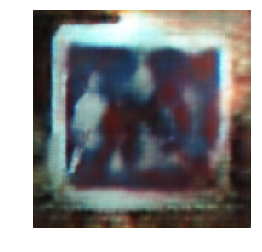

INFO:root:speed: 62.62482624139419 samples/s
INFO:root:discriminator loss = 0.338383, generator loss = 15.278143, binary training acc = 0.914000 at iter 0 epoch 16
INFO:root:speed: 29.206821394500267 samples/s
INFO:root:discriminator loss = 0.558324, generator loss = 17.798923, binary training acc = 0.807080 at iter 10 epoch 16
INFO:root:speed: 29.62418016750504 samples/s
INFO:root:discriminator loss = 0.513738, generator loss = 18.269051, binary training acc = 0.795415 at iter 20 epoch 16
INFO:root:speed: 29.005369131229756 samples/s
INFO:root:discriminator loss = 0.507881, generator loss = 19.078754, binary training acc = 0.762851 at iter 30 epoch 16
INFO:root:speed: 28.742638402151226 samples/s
INFO:root:discriminator loss = 0.510377, generator loss = 14.436197, binary training acc = 0.745243 at iter 40 epoch 16
INFO:root:speed: 29.036573461913893 samples/s
INFO:root:discriminator loss = 0.231279, generator loss = 15.631172, binary training acc = 0.749090 at iter 50 epoch 16
INFO:ro

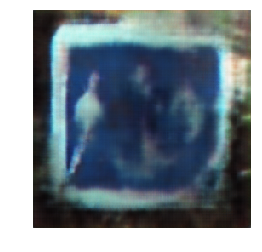

INFO:root:speed: 61.083579698536376 samples/s
INFO:root:discriminator loss = 0.459946, generator loss = 18.363819, binary training acc = 0.717755 at iter 0 epoch 17
INFO:root:speed: 29.2349352368353 samples/s
INFO:root:discriminator loss = 0.631452, generator loss = 18.583376, binary training acc = 0.816345 at iter 10 epoch 17
INFO:root:speed: 28.936671640874604 samples/s
INFO:root:discriminator loss = 0.310764, generator loss = 18.194880, binary training acc = 0.796426 at iter 20 epoch 17
INFO:root:speed: 29.092261006780074 samples/s
INFO:root:discriminator loss = 0.787389, generator loss = 19.666079, binary training acc = 0.770502 at iter 30 epoch 17
INFO:root:speed: 29.039367854489665 samples/s
INFO:root:discriminator loss = 0.527396, generator loss = 14.813042, binary training acc = 0.743822 at iter 40 epoch 17
INFO:root:speed: 28.343434821244546 samples/s
INFO:root:discriminator loss = 0.235708, generator loss = 15.339808, binary training acc = 0.748150 at iter 50 epoch 17
INFO:ro

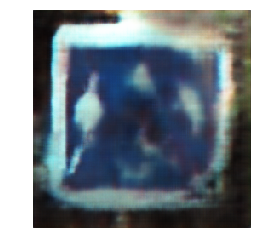

INFO:root:speed: 57.605440943594985 samples/s
INFO:root:discriminator loss = 0.508149, generator loss = 16.599625, binary training acc = 0.842000 at iter 0 epoch 18
INFO:root:speed: 29.412906519458517 samples/s
INFO:root:discriminator loss = 0.097193, generator loss = 17.189819, binary training acc = 0.812701 at iter 10 epoch 18
INFO:root:speed: 28.866888142377636 samples/s
INFO:root:discriminator loss = 0.229346, generator loss = 17.823521, binary training acc = 0.827712 at iter 20 epoch 18
INFO:root:speed: 29.707879525360006 samples/s
INFO:root:discriminator loss = 0.568654, generator loss = 18.414400, binary training acc = 0.811670 at iter 30 epoch 18
INFO:root:speed: 29.385108280549296 samples/s
INFO:root:discriminator loss = 0.614611, generator loss = 13.991063, binary training acc = 0.770430 at iter 40 epoch 18
INFO:root:speed: 29.406678772496864 samples/s
INFO:root:discriminator loss = 0.262569, generator loss = 14.872469, binary training acc = 0.773080 at iter 50 epoch 18
INFO:

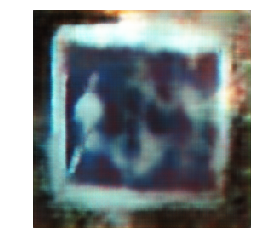

INFO:root:speed: 56.219392542154786 samples/s
INFO:root:discriminator loss = 0.273546, generator loss = 13.988710, binary training acc = 0.965184 at iter 0 epoch 19
INFO:root:speed: 29.310484831840313 samples/s
INFO:root:discriminator loss = 0.257102, generator loss = 17.061960, binary training acc = 0.875878 at iter 10 epoch 19
INFO:root:speed: 29.24618777703943 samples/s
INFO:root:discriminator loss = 0.239528, generator loss = 17.639244, binary training acc = 0.788082 at iter 20 epoch 19
INFO:root:speed: 29.065327106754324 samples/s
INFO:root:discriminator loss = 0.513949, generator loss = 18.807444, binary training acc = 0.745336 at iter 30 epoch 19
INFO:root:speed: 28.9279103065281 samples/s
INFO:root:discriminator loss = 0.597910, generator loss = 13.601357, binary training acc = 0.726475 at iter 40 epoch 19
INFO:root:speed: 29.325485803620182 samples/s
INFO:root:discriminator loss = 0.263935, generator loss = 14.565277, binary training acc = 0.735393 at iter 50 epoch 19
INFO:roo

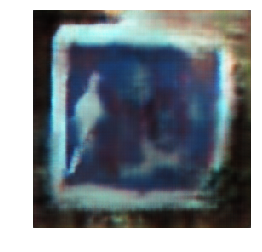

INFO:root:speed: 60.882485288524904 samples/s
INFO:root:discriminator loss = 0.448335, generator loss = 16.506256, binary training acc = 0.896327 at iter 0 epoch 20
INFO:root:speed: 29.191169510871077 samples/s
INFO:root:discriminator loss = 0.329311, generator loss = 16.052101, binary training acc = 0.787933 at iter 10 epoch 20
INFO:root:speed: 29.382164623467602 samples/s
INFO:root:discriminator loss = 0.503221, generator loss = 17.464945, binary training acc = 0.809110 at iter 20 epoch 20
INFO:root:speed: 29.299919595223773 samples/s
INFO:root:discriminator loss = 0.681862, generator loss = 18.917490, binary training acc = 0.759776 at iter 30 epoch 20
INFO:root:speed: 29.42283099513373 samples/s
INFO:root:discriminator loss = 0.642950, generator loss = 14.536821, binary training acc = 0.731044 at iter 40 epoch 20
INFO:root:speed: 29.43290674851706 samples/s
INFO:root:discriminator loss = 0.348378, generator loss = 14.533884, binary training acc = 0.739335 at iter 50 epoch 20
INFO:ro

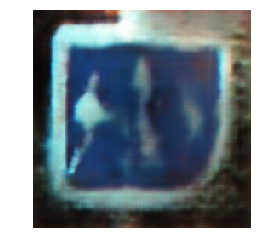

INFO:root:speed: 57.36498527684053 samples/s
INFO:root:discriminator loss = 0.340841, generator loss = 14.975482, binary training acc = 0.930612 at iter 0 epoch 21
INFO:root:speed: 28.554591550523124 samples/s
INFO:root:discriminator loss = 0.774907, generator loss = 16.774139, binary training acc = 0.850957 at iter 10 epoch 21
INFO:root:speed: 29.01769023750718 samples/s
INFO:root:discriminator loss = 0.161060, generator loss = 17.318611, binary training acc = 0.811926 at iter 20 epoch 21
INFO:root:speed: 28.680786291659857 samples/s
INFO:root:discriminator loss = 0.590512, generator loss = 18.364986, binary training acc = 0.751893 at iter 30 epoch 21
INFO:root:speed: 29.634980590989187 samples/s
INFO:root:discriminator loss = 0.659450, generator loss = 14.514687, binary training acc = 0.721929 at iter 40 epoch 21
INFO:root:speed: 29.145711742424506 samples/s
INFO:root:discriminator loss = 0.303351, generator loss = 14.217059, binary training acc = 0.737023 at iter 50 epoch 21
INFO:ro

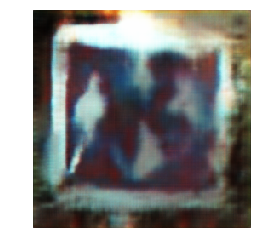

INFO:root:speed: 62.50937423620095 samples/s
INFO:root:discriminator loss = 0.191988, generator loss = 13.412363, binary training acc = 0.968367 at iter 0 epoch 22
INFO:root:speed: 29.934447312696665 samples/s
INFO:root:discriminator loss = 0.296952, generator loss = 17.047108, binary training acc = 0.916126 at iter 10 epoch 22
INFO:root:speed: 29.870428425129223 samples/s
INFO:root:discriminator loss = 0.296833, generator loss = 16.608059, binary training acc = 0.882107 at iter 20 epoch 22
INFO:root:speed: 29.93053821111988 samples/s
INFO:root:discriminator loss = 0.516221, generator loss = 17.757458, binary training acc = 0.811950 at iter 30 epoch 22
INFO:root:speed: 29.33533084483686 samples/s
INFO:root:discriminator loss = 0.683286, generator loss = 13.614413, binary training acc = 0.785782 at iter 40 epoch 22
INFO:root:speed: 29.941969330623476 samples/s
INFO:root:discriminator loss = 0.262742, generator loss = 13.974689, binary training acc = 0.787846 at iter 50 epoch 22
INFO:roo

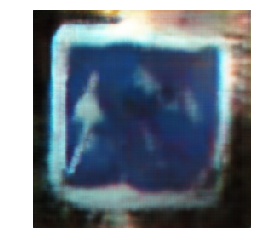

INFO:root:speed: 60.9648728827725 samples/s
INFO:root:discriminator loss = 0.540116, generator loss = 15.014234, binary training acc = 0.796122 at iter 0 epoch 23
INFO:root:speed: 29.279343363725147 samples/s
INFO:root:discriminator loss = 1.770649, generator loss = 17.257607, binary training acc = 0.795844 at iter 10 epoch 23
INFO:root:speed: 29.571171537025442 samples/s
INFO:root:discriminator loss = 0.348700, generator loss = 16.711248, binary training acc = 0.775434 at iter 20 epoch 23
INFO:root:speed: 29.081328214540026 samples/s
INFO:root:discriminator loss = 0.344501, generator loss = 17.598944, binary training acc = 0.752248 at iter 30 epoch 23
INFO:root:speed: 29.084554752178583 samples/s
INFO:root:discriminator loss = 0.513734, generator loss = 13.220716, binary training acc = 0.737541 at iter 40 epoch 23
INFO:root:speed: 29.502157285604355 samples/s
INFO:root:discriminator loss = 0.259177, generator loss = 14.309387, binary training acc = 0.738158 at iter 50 epoch 23
INFO:ro

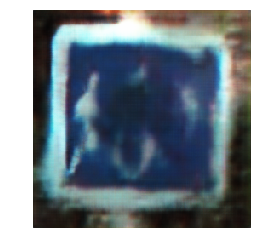

INFO:root:speed: 60.14132329999082 samples/s
INFO:root:discriminator loss = 0.457422, generator loss = 13.576584, binary training acc = 0.862776 at iter 0 epoch 24
INFO:root:speed: 29.553294241823405 samples/s
INFO:root:discriminator loss = 0.240843, generator loss = 16.999777, binary training acc = 0.741878 at iter 10 epoch 24
INFO:root:speed: 28.816057776336546 samples/s
INFO:root:discriminator loss = 0.114471, generator loss = 15.926664, binary training acc = 0.765687 at iter 20 epoch 24
INFO:root:speed: 29.498235790145884 samples/s
INFO:root:discriminator loss = 0.454470, generator loss = 18.071398, binary training acc = 0.746226 at iter 30 epoch 24
INFO:root:speed: 28.897436692399644 samples/s
INFO:root:discriminator loss = 0.682797, generator loss = 14.054558, binary training acc = 0.729731 at iter 40 epoch 24
INFO:root:speed: 29.150208602788737 samples/s
INFO:root:discriminator loss = 0.316643, generator loss = 13.775187, binary training acc = 0.743480 at iter 50 epoch 24
INFO:r

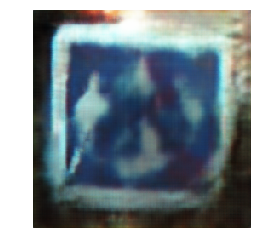

INFO:root:speed: 60.68508114630642 samples/s
INFO:root:discriminator loss = 0.256439, generator loss = 12.571381, binary training acc = 0.879224 at iter 0 epoch 25
INFO:root:speed: 29.400804012351088 samples/s
INFO:root:discriminator loss = 0.482328, generator loss = 16.924135, binary training acc = 0.832939 at iter 10 epoch 25
INFO:root:speed: 29.28339087421412 samples/s
INFO:root:discriminator loss = 0.180530, generator loss = 16.266880, binary training acc = 0.856328 at iter 20 epoch 25
INFO:root:speed: 29.167297164982866 samples/s
INFO:root:discriminator loss = 0.727615, generator loss = 18.481373, binary training acc = 0.788607 at iter 30 epoch 25
INFO:root:speed: 29.418806751947436 samples/s
INFO:root:discriminator loss = 0.482405, generator loss = 12.932162, binary training acc = 0.756848 at iter 40 epoch 25
INFO:root:speed: 29.40626643203186 samples/s
INFO:root:discriminator loss = 0.284977, generator loss = 14.612761, binary training acc = 0.760018 at iter 50 epoch 25
INFO:roo

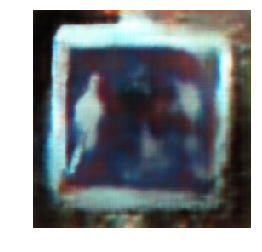

INFO:root:speed: 60.599945097019344 samples/s
INFO:root:discriminator loss = 0.341020, generator loss = 12.296656, binary training acc = 0.925020 at iter 0 epoch 26
INFO:root:speed: 29.27954775661901 samples/s
INFO:root:discriminator loss = 0.344548, generator loss = 15.899012, binary training acc = 0.847295 at iter 10 epoch 26
INFO:root:speed: 29.622318099732542 samples/s
INFO:root:discriminator loss = 0.250498, generator loss = 15.397840, binary training acc = 0.848019 at iter 20 epoch 26
INFO:root:speed: 29.288114384351754 samples/s
INFO:root:discriminator loss = 0.702667, generator loss = 17.889828, binary training acc = 0.792236 at iter 30 epoch 26
INFO:root:speed: 29.25991863067367 samples/s
INFO:root:discriminator loss = 0.769003, generator loss = 12.661576, binary training acc = 0.739309 at iter 40 epoch 26
INFO:root:speed: 28.99909220199439 samples/s
INFO:root:discriminator loss = 0.321092, generator loss = 14.527536, binary training acc = 0.753581 at iter 50 epoch 26
INFO:roo

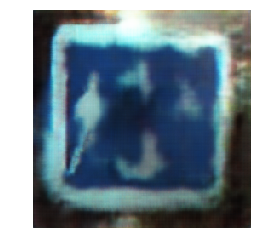

INFO:root:speed: 56.48605189229373 samples/s
INFO:root:discriminator loss = 0.345185, generator loss = 12.310089, binary training acc = 0.936735 at iter 0 epoch 27
INFO:root:speed: 29.151768648759855 samples/s
INFO:root:discriminator loss = 0.076707, generator loss = 15.702423, binary training acc = 0.819373 at iter 10 epoch 27
INFO:root:speed: 29.277279155445918 samples/s
INFO:root:discriminator loss = 0.229783, generator loss = 15.642649, binary training acc = 0.812117 at iter 20 epoch 27
INFO:root:speed: 29.360691725281125 samples/s
INFO:root:discriminator loss = 0.539801, generator loss = 18.453121, binary training acc = 0.759751 at iter 30 epoch 27
INFO:root:speed: 29.012331076290536 samples/s
INFO:root:discriminator loss = 0.520339, generator loss = 13.457164, binary training acc = 0.738262 at iter 40 epoch 27
INFO:root:speed: 29.109059451326367 samples/s
INFO:root:discriminator loss = 0.271529, generator loss = 13.097486, binary training acc = 0.751892 at iter 50 epoch 27
INFO:r

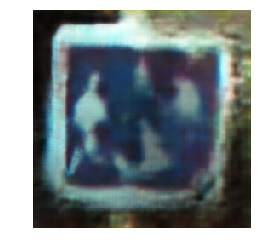

INFO:root:speed: 58.782942129486884 samples/s
INFO:root:discriminator loss = 0.712737, generator loss = 12.913196, binary training acc = 0.599878 at iter 0 epoch 28
INFO:root:speed: 28.706383182591257 samples/s
INFO:root:discriminator loss = 0.320879, generator loss = 15.681877, binary training acc = 0.803365 at iter 10 epoch 28
INFO:root:speed: 29.27067972981366 samples/s
INFO:root:discriminator loss = 0.163719, generator loss = 15.875908, binary training acc = 0.836638 at iter 20 epoch 28
INFO:root:speed: 29.223060158631952 samples/s
INFO:root:discriminator loss = 1.085770, generator loss = 17.918953, binary training acc = 0.783966 at iter 30 epoch 28
INFO:root:speed: 28.524491608531427 samples/s
INFO:root:discriminator loss = 0.462365, generator loss = 13.098261, binary training acc = 0.746669 at iter 40 epoch 28
INFO:root:speed: 29.265022529782712 samples/s
INFO:root:discriminator loss = 0.234362, generator loss = 13.831670, binary training acc = 0.749964 at iter 50 epoch 28
INFO:r

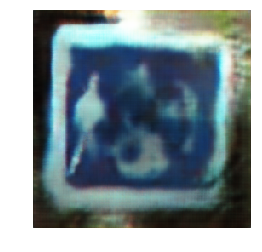

INFO:root:speed: 58.63641765004397 samples/s
INFO:root:discriminator loss = 0.196734, generator loss = 13.424939, binary training acc = 0.970327 at iter 0 epoch 29
INFO:root:speed: 29.12751565993972 samples/s
INFO:root:discriminator loss = 0.451631, generator loss = 15.808157, binary training acc = 0.749896 at iter 10 epoch 29
INFO:root:speed: 29.72137346160169 samples/s
INFO:root:discriminator loss = 0.168778, generator loss = 15.455630, binary training acc = 0.764795 at iter 20 epoch 29
INFO:root:speed: 29.817595513893252 samples/s
INFO:root:discriminator loss = 0.556343, generator loss = 18.257524, binary training acc = 0.746768 at iter 30 epoch 29
INFO:root:speed: 29.90893908688081 samples/s
INFO:root:discriminator loss = 0.632034, generator loss = 12.472092, binary training acc = 0.711927 at iter 40 epoch 29
INFO:root:speed: 29.8994513128358 samples/s
INFO:root:discriminator loss = 0.210157, generator loss = 13.073016, binary training acc = 0.733597 at iter 50 epoch 29
INFO:root:s

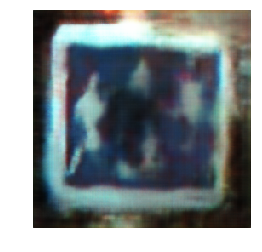

INFO:root:speed: 61.04357444331247 samples/s
INFO:root:discriminator loss = 0.374002, generator loss = 12.229546, binary training acc = 0.899755 at iter 0 epoch 30
INFO:root:speed: 29.32876674971453 samples/s
INFO:root:discriminator loss = 0.628963, generator loss = 15.597330, binary training acc = 0.770160 at iter 10 epoch 30
INFO:root:speed: 28.80525242258377 samples/s
INFO:root:discriminator loss = 0.321149, generator loss = 15.660452, binary training acc = 0.779899 at iter 20 epoch 30
INFO:root:speed: 29.598571129159396 samples/s
INFO:root:discriminator loss = 0.582882, generator loss = 17.808140, binary training acc = 0.750569 at iter 30 epoch 30
INFO:root:speed: 29.128587768685495 samples/s
INFO:root:discriminator loss = 0.779664, generator loss = 12.809064, binary training acc = 0.720672 at iter 40 epoch 30
INFO:root:speed: 29.582475804642858 samples/s
INFO:root:discriminator loss = 0.252763, generator loss = 15.032010, binary training acc = 0.739020 at iter 50 epoch 30
INFO:roo

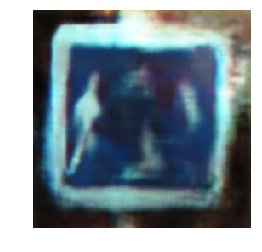

INFO:root:speed: 57.65366323024055 samples/s
INFO:root:discriminator loss = 0.256959, generator loss = 11.893979, binary training acc = 0.975510 at iter 0 epoch 31
INFO:root:speed: 29.250450510764836 samples/s
INFO:root:discriminator loss = 0.309118, generator loss = 14.904981, binary training acc = 0.847414 at iter 10 epoch 31
INFO:root:speed: 29.303031044010744 samples/s
INFO:root:discriminator loss = 0.737788, generator loss = 15.524055, binary training acc = 0.818962 at iter 20 epoch 31
INFO:root:speed: 29.102757761734104 samples/s
INFO:root:discriminator loss = 0.944407, generator loss = 17.835323, binary training acc = 0.775043 at iter 30 epoch 31
INFO:root:speed: 29.397033035272482 samples/s
INFO:root:discriminator loss = 0.642109, generator loss = 12.242379, binary training acc = 0.752181 at iter 40 epoch 31
INFO:root:speed: 29.39386039418837 samples/s
INFO:root:discriminator loss = 0.260896, generator loss = 13.361392, binary training acc = 0.756356 at iter 50 epoch 31
INFO:ro

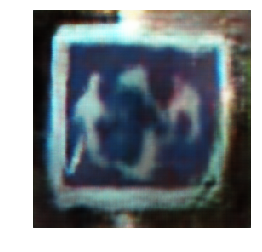

INFO:root:speed: 55.97667140445352 samples/s
INFO:root:discriminator loss = 0.297869, generator loss = 12.085376, binary training acc = 0.952898 at iter 0 epoch 32
INFO:root:speed: 29.290527847728228 samples/s
INFO:root:discriminator loss = 0.516646, generator loss = 16.386395, binary training acc = 0.748850 at iter 10 epoch 32
INFO:root:speed: 29.289464238578006 samples/s
INFO:root:discriminator loss = 0.259461, generator loss = 14.959361, binary training acc = 0.722321 at iter 20 epoch 32
INFO:root:speed: 29.40622519862136 samples/s
INFO:root:discriminator loss = 0.565554, generator loss = 16.959000, binary training acc = 0.705950 at iter 30 epoch 32
INFO:root:speed: 29.368503897311513 samples/s
INFO:root:discriminator loss = 0.416835, generator loss = 11.527761, binary training acc = 0.698478 at iter 40 epoch 32
INFO:root:speed: 29.28510833797062 samples/s
INFO:root:discriminator loss = 0.277689, generator loss = 13.628685, binary training acc = 0.715954 at iter 50 epoch 32
INFO:roo

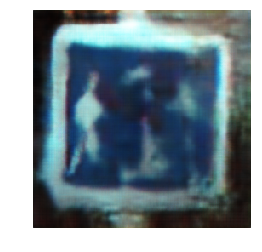

INFO:root:speed: 61.097282431361585 samples/s
INFO:root:discriminator loss = 0.149048, generator loss = 11.175950, binary training acc = 0.991551 at iter 0 epoch 33
INFO:root:speed: 29.670913011244984 samples/s
INFO:root:discriminator loss = 0.370715, generator loss = 15.374929, binary training acc = 0.776345 at iter 10 epoch 33
INFO:root:speed: 29.500684008960693 samples/s
INFO:root:discriminator loss = 0.276032, generator loss = 14.941892, binary training acc = 0.777537 at iter 20 epoch 33
INFO:root:speed: 30.028981522847292 samples/s
INFO:root:discriminator loss = 0.307535, generator loss = 16.506836, binary training acc = 0.734511 at iter 30 epoch 33
INFO:root:speed: 29.299919595223773 samples/s
INFO:root:discriminator loss = 0.504309, generator loss = 11.525005, binary training acc = 0.718685 at iter 40 epoch 33
INFO:root:speed: 29.81844343935152 samples/s
INFO:root:discriminator loss = 0.280346, generator loss = 13.843623, binary training acc = 0.732816 at iter 50 epoch 33
INFO:r

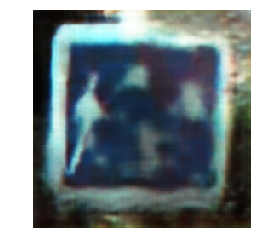

INFO:root:speed: 60.159179347132316 samples/s
INFO:root:discriminator loss = 0.206069, generator loss = 11.399469, binary training acc = 0.988694 at iter 0 epoch 34
INFO:root:speed: 28.84453482446615 samples/s
INFO:root:discriminator loss = 0.902185, generator loss = 15.437518, binary training acc = 0.916508 at iter 10 epoch 34
INFO:root:speed: 29.366427098612654 samples/s
INFO:root:discriminator loss = 0.338132, generator loss = 14.822090, binary training acc = 0.842047 at iter 20 epoch 34
INFO:root:speed: 28.97471217360909 samples/s
INFO:root:discriminator loss = 0.619313, generator loss = 17.147318, binary training acc = 0.805005 at iter 30 epoch 34
INFO:root:speed: 28.783547490097366 samples/s
INFO:root:discriminator loss = 0.644213, generator loss = 11.507551, binary training acc = 0.769948 at iter 40 epoch 34
INFO:root:speed: 28.407628730940196 samples/s
INFO:root:discriminator loss = 0.256732, generator loss = 12.846171, binary training acc = 0.769871 at iter 50 epoch 34
INFO:ro

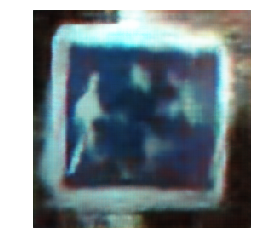

INFO:root:speed: 56.229491933516194 samples/s
INFO:root:discriminator loss = 0.667633, generator loss = 12.435586, binary training acc = 0.673184 at iter 0 epoch 35
INFO:root:speed: 29.253735090848096 samples/s
INFO:root:discriminator loss = 0.425795, generator loss = 14.751394, binary training acc = 0.755295 at iter 10 epoch 35
INFO:root:speed: 29.221472114815203 samples/s
INFO:root:discriminator loss = 0.398536, generator loss = 15.128693, binary training acc = 0.796791 at iter 20 epoch 35
INFO:root:speed: 29.03305610643298 samples/s
INFO:root:discriminator loss = 0.565835, generator loss = 16.877325, binary training acc = 0.738727 at iter 30 epoch 35
INFO:root:speed: 28.99582446146614 samples/s
INFO:root:discriminator loss = 0.641357, generator loss = 11.510221, binary training acc = 0.707953 at iter 40 epoch 35
INFO:root:speed: 29.008879780948345 samples/s
INFO:root:discriminator loss = 0.264357, generator loss = 13.448023, binary training acc = 0.713465 at iter 50 epoch 35
INFO:ro

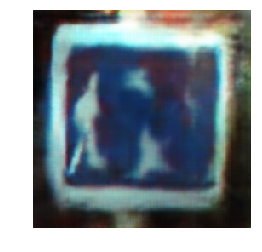

INFO:root:speed: 58.27218948064542 samples/s
INFO:root:discriminator loss = 0.234612, generator loss = 11.133566, binary training acc = 0.986898 at iter 0 epoch 36
INFO:root:speed: 29.145023156592767 samples/s
INFO:root:discriminator loss = 0.219262, generator loss = 14.978582, binary training acc = 0.889714 at iter 10 epoch 36
INFO:root:speed: 29.597067322449874 samples/s
INFO:root:discriminator loss = 0.435602, generator loss = 14.726625, binary training acc = 0.797901 at iter 20 epoch 36
INFO:root:speed: 29.37105403209994 samples/s
INFO:root:discriminator loss = 0.690104, generator loss = 16.723654, binary training acc = 0.756918 at iter 30 epoch 36
INFO:root:speed: 29.272906447947694 samples/s
INFO:root:discriminator loss = 0.508463, generator loss = 11.613495, binary training acc = 0.736616 at iter 40 epoch 36
INFO:root:speed: 29.22206252120606 samples/s
INFO:root:discriminator loss = 0.228049, generator loss = 13.232674, binary training acc = 0.760161 at iter 50 epoch 36
INFO:roo

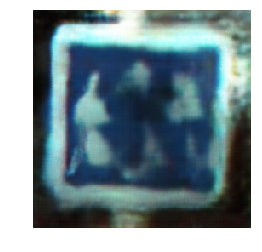

INFO:root:speed: 57.48645863029319 samples/s
INFO:root:discriminator loss = 0.339082, generator loss = 11.717240, binary training acc = 0.940857 at iter 0 epoch 37
INFO:root:speed: 29.022187840349403 samples/s
INFO:root:discriminator loss = 0.579439, generator loss = 14.793686, binary training acc = 0.778341 at iter 10 epoch 37
INFO:root:speed: 29.272293555955997 samples/s
INFO:root:discriminator loss = 0.354873, generator loss = 14.049563, binary training acc = 0.773020 at iter 20 epoch 37
INFO:root:speed: 28.78990929845298 samples/s
INFO:root:discriminator loss = 0.655108, generator loss = 17.061106, binary training acc = 0.722436 at iter 30 epoch 37
INFO:root:speed: 29.34384803311123 samples/s
INFO:root:discriminator loss = 0.614362, generator loss = 11.585327, binary training acc = 0.711218 at iter 40 epoch 37
INFO:root:speed: 29.311324644466964 samples/s
INFO:root:discriminator loss = 0.210902, generator loss = 13.290935, binary training acc = 0.728110 at iter 50 epoch 37
INFO:roo

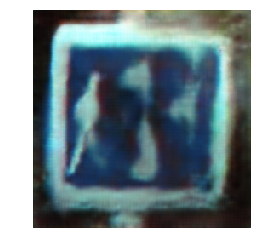

INFO:root:speed: 57.20561158104632 samples/s
INFO:root:discriminator loss = 0.180800, generator loss = 11.168172, binary training acc = 0.978898 at iter 0 epoch 38
INFO:root:speed: 28.984082714051354 samples/s
INFO:root:discriminator loss = 0.389229, generator loss = 14.093305, binary training acc = 0.915573 at iter 10 epoch 38
INFO:root:speed: 29.43648034271293 samples/s
INFO:root:discriminator loss = 0.558527, generator loss = 14.051450, binary training acc = 0.905843 at iter 20 epoch 38
INFO:root:speed: 29.165106764089884 samples/s
INFO:root:discriminator loss = 0.417310, generator loss = 16.894278, binary training acc = 0.818195 at iter 30 epoch 38
INFO:root:speed: 28.853801491428413 samples/s
INFO:root:discriminator loss = 0.562114, generator loss = 10.923782, binary training acc = 0.748970 at iter 40 epoch 38
INFO:root:speed: 29.631274907294177 samples/s
INFO:root:discriminator loss = 0.273632, generator loss = 12.499384, binary training acc = 0.752335 at iter 50 epoch 38
INFO:ro

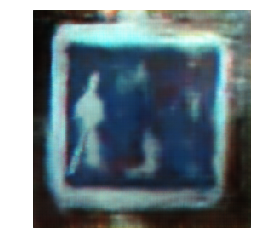

INFO:root:speed: 59.62857813066441 samples/s
INFO:root:discriminator loss = 0.080381, generator loss = 11.160719, binary training acc = 0.999918 at iter 0 epoch 39
INFO:root:speed: 29.037076010841385 samples/s
INFO:root:discriminator loss = 0.816791, generator loss = 15.030871, binary training acc = 0.749506 at iter 10 epoch 39
INFO:root:speed: 28.854655038501043 samples/s
INFO:root:discriminator loss = 0.468292, generator loss = 14.517654, binary training acc = 0.793631 at iter 20 epoch 39
INFO:root:speed: 29.461830237981513 samples/s
INFO:root:discriminator loss = 0.613890, generator loss = 17.615082, binary training acc = 0.751608 at iter 30 epoch 39
INFO:root:speed: 29.13617569910639 samples/s
INFO:root:discriminator loss = 0.553650, generator loss = 10.908489, binary training acc = 0.730941 at iter 40 epoch 39
INFO:root:speed: 29.25555110701287 samples/s
INFO:root:discriminator loss = 0.319335, generator loss = 13.549257, binary training acc = 0.747834 at iter 50 epoch 39
INFO:roo

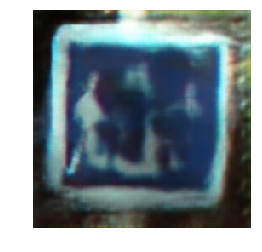

INFO:root:speed: 57.3100393243535 samples/s
INFO:root:discriminator loss = 0.214346, generator loss = 10.300104, binary training acc = 0.984857 at iter 0 epoch 40
INFO:root:speed: 28.869749324941477 samples/s
INFO:root:discriminator loss = 0.203910, generator loss = 13.739682, binary training acc = 0.929043 at iter 10 epoch 40
INFO:root:speed: 29.224546561138908 samples/s
INFO:root:discriminator loss = 0.261176, generator loss = 13.739740, binary training acc = 0.873607 at iter 20 epoch 40
INFO:root:speed: 29.261715000111625 samples/s
INFO:root:discriminator loss = 0.803110, generator loss = 16.513365, binary training acc = 0.792811 at iter 30 epoch 40
INFO:root:speed: 29.16222729314327 samples/s
INFO:root:discriminator loss = 0.561405, generator loss = 10.525703, binary training acc = 0.758625 at iter 40 epoch 40
INFO:root:speed: 29.286621508675374 samples/s
INFO:root:discriminator loss = 0.250893, generator loss = 11.843523, binary training acc = 0.760878 at iter 50 epoch 40
INFO:roo

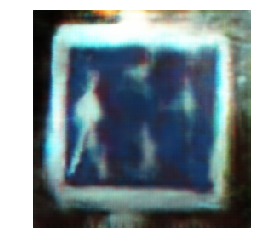

INFO:root:speed: 57.741366611829655 samples/s
INFO:root:discriminator loss = 0.218263, generator loss = 10.799939, binary training acc = 0.972327 at iter 0 epoch 41
INFO:root:speed: 28.982540563287436 samples/s
INFO:root:discriminator loss = 0.142072, generator loss = 14.034999, binary training acc = 0.891655 at iter 10 epoch 41
INFO:root:speed: 29.171638375798615 samples/s
INFO:root:discriminator loss = 0.105003, generator loss = 13.339091, binary training acc = 0.883236 at iter 20 epoch 41
INFO:root:speed: 28.75627498166012 samples/s
INFO:root:discriminator loss = 0.341673, generator loss = 15.780739, binary training acc = 0.817667 at iter 30 epoch 41
INFO:root:speed: 28.759331191738976 samples/s
INFO:root:discriminator loss = 0.547373, generator loss = 10.544268, binary training acc = 0.778431 at iter 40 epoch 41
INFO:root:speed: 28.591730949089413 samples/s
INFO:root:discriminator loss = 0.272228, generator loss = 12.019159, binary training acc = 0.782265 at iter 50 epoch 41
INFO:r

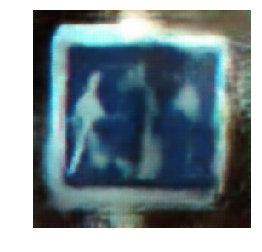

INFO:root:speed: 61.813112154518635 samples/s
INFO:root:discriminator loss = 0.153736, generator loss = 11.162288, binary training acc = 0.979878 at iter 0 epoch 42
INFO:root:speed: 29.37181504520649 samples/s
INFO:root:discriminator loss = 0.452968, generator loss = 14.847528, binary training acc = 0.848850 at iter 10 epoch 42
INFO:root:speed: 29.20131083078461 samples/s
INFO:root:discriminator loss = 0.376874, generator loss = 13.774460, binary training acc = 0.811452 at iter 20 epoch 42
INFO:root:speed: 29.560813406132894 samples/s
INFO:root:discriminator loss = 0.535294, generator loss = 15.929626, binary training acc = 0.756507 at iter 30 epoch 42
INFO:root:speed: 28.834243303777054 samples/s
INFO:root:discriminator loss = 0.427924, generator loss = 10.427917, binary training acc = 0.749508 at iter 40 epoch 42
INFO:root:speed: 29.401236809306774 samples/s
INFO:root:discriminator loss = 0.360109, generator loss = 12.094563, binary training acc = 0.753734 at iter 50 epoch 42
INFO:ro

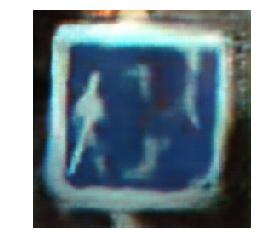

INFO:root:speed: 59.35299453352409 samples/s
INFO:root:discriminator loss = 1.101312, generator loss = 11.011662, binary training acc = 0.515143 at iter 0 epoch 43
INFO:root:speed: 28.549557527545193 samples/s
INFO:root:discriminator loss = 0.729904, generator loss = 14.809477, binary training acc = 0.770768 at iter 10 epoch 43
INFO:root:speed: 29.255102183162446 samples/s
INFO:root:discriminator loss = 0.506760, generator loss = 13.510666, binary training acc = 0.788587 at iter 20 epoch 43
INFO:root:speed: 28.535456170226084 samples/s
INFO:root:discriminator loss = 0.510298, generator loss = 16.190134, binary training acc = 0.726332 at iter 30 epoch 43
INFO:root:speed: 28.755525816394808 samples/s
INFO:root:discriminator loss = 0.604415, generator loss = 11.082997, binary training acc = 0.723587 at iter 40 epoch 43
INFO:root:speed: 28.45523171286858 samples/s
INFO:root:discriminator loss = 0.202844, generator loss = 12.062342, binary training acc = 0.736030 at iter 50 epoch 43
INFO:ro

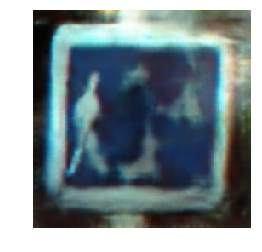

INFO:root:speed: 60.85828042113083 samples/s
INFO:root:discriminator loss = 0.110603, generator loss = 10.095838, binary training acc = 0.998980 at iter 0 epoch 44
INFO:root:speed: 28.561980589611657 samples/s
INFO:root:discriminator loss = 0.439624, generator loss = 13.777547, binary training acc = 0.915521 at iter 10 epoch 44
INFO:root:speed: 28.947735662971738 samples/s
INFO:root:discriminator loss = 0.153090, generator loss = 12.733618, binary training acc = 0.823432 at iter 20 epoch 44
INFO:root:speed: 28.983822339420602 samples/s
INFO:root:discriminator loss = 0.526331, generator loss = 16.015438, binary training acc = 0.761427 at iter 30 epoch 44
INFO:root:speed: 28.760652464295216 samples/s
INFO:root:discriminator loss = 0.490875, generator loss = 11.012320, binary training acc = 0.720431 at iter 40 epoch 44
INFO:root:speed: 29.489587288195178 samples/s
INFO:root:discriminator loss = 0.245797, generator loss = 12.278105, binary training acc = 0.745037 at iter 50 epoch 44
INFO:r

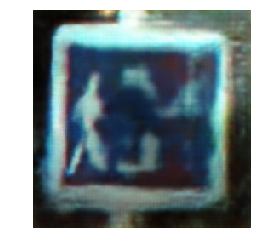

INFO:root:speed: 60.46758788717572 samples/s
INFO:root:discriminator loss = 0.237630, generator loss = 10.334085, binary training acc = 0.976612 at iter 0 epoch 45
INFO:root:speed: 29.87406650308584 samples/s
INFO:root:discriminator loss = 0.519189, generator loss = 14.260107, binary training acc = 0.750531 at iter 10 epoch 45
INFO:root:speed: 29.57296462641632 samples/s
INFO:root:discriminator loss = 0.545678, generator loss = 13.567244, binary training acc = 0.736917 at iter 20 epoch 45
INFO:root:speed: 29.374016034781246 samples/s
INFO:root:discriminator loss = 0.293023, generator loss = 15.757814, binary training acc = 0.748116 at iter 30 epoch 45
INFO:root:speed: 29.290486938255604 samples/s
INFO:root:discriminator loss = 0.695684, generator loss = 11.316483, binary training acc = 0.741889 at iter 40 epoch 45
INFO:root:speed: 29.776994005276265 samples/s
INFO:root:discriminator loss = 0.246597, generator loss = 12.035743, binary training acc = 0.754535 at iter 50 epoch 45
INFO:roo

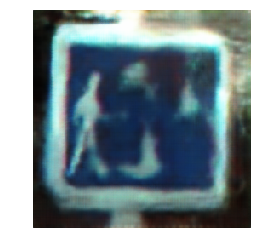

INFO:root:speed: 61.31270428777752 samples/s
INFO:root:discriminator loss = 0.255413, generator loss = 9.982886, binary training acc = 0.959061 at iter 0 epoch 46
INFO:root:speed: 29.221329606502074 samples/s
INFO:root:discriminator loss = 0.107323, generator loss = 13.698198, binary training acc = 0.798798 at iter 10 epoch 46
INFO:root:speed: 28.88973379840092 samples/s
INFO:root:discriminator loss = 0.286547, generator loss = 13.409645, binary training acc = 0.831903 at iter 20 epoch 46
INFO:root:speed: 29.358246136422654 samples/s
INFO:root:discriminator loss = 0.341513, generator loss = 15.551549, binary training acc = 0.789572 at iter 30 epoch 46
INFO:root:speed: 29.11308022383657 samples/s
INFO:root:discriminator loss = 0.872611, generator loss = 11.185944, binary training acc = 0.766881 at iter 40 epoch 46
INFO:root:speed: 29.367085062451295 samples/s
INFO:root:discriminator loss = 0.205635, generator loss = 11.685220, binary training acc = 0.784409 at iter 50 epoch 46
INFO:root

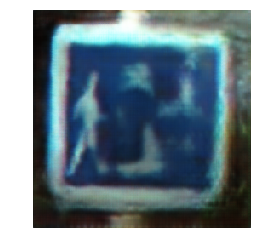

INFO:root:speed: 57.5471120825084 samples/s
INFO:root:discriminator loss = 0.325822, generator loss = 11.211642, binary training acc = 0.936735 at iter 0 epoch 47
INFO:root:speed: 29.387414214097788 samples/s
INFO:root:discriminator loss = 0.640991, generator loss = 14.872366, binary training acc = 0.880037 at iter 10 epoch 47
INFO:root:speed: 29.42163392572172 samples/s
INFO:root:discriminator loss = 0.181456, generator loss = 13.179919, binary training acc = 0.861240 at iter 20 epoch 47
INFO:root:speed: 29.269311181266765 samples/s
INFO:root:discriminator loss = 0.237220, generator loss = 15.257074, binary training acc = 0.799315 at iter 30 epoch 47
INFO:root:speed: 29.416908516819163 samples/s
INFO:root:discriminator loss = 0.448031, generator loss = 10.462706, binary training acc = 0.774685 at iter 40 epoch 47
INFO:root:speed: 28.745494706730167 samples/s
INFO:root:discriminator loss = 0.230100, generator loss = 11.529387, binary training acc = 0.780855 at iter 50 epoch 47
INFO:roo

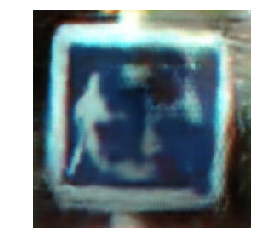

INFO:root:speed: 57.29007795202133 samples/s
INFO:root:discriminator loss = 0.362450, generator loss = 10.002146, binary training acc = 0.894612 at iter 0 epoch 48
INFO:root:speed: 29.05010815082521 samples/s
INFO:root:discriminator loss = 0.685350, generator loss = 14.870883, binary training acc = 0.819774 at iter 10 epoch 48
INFO:root:speed: 29.70293551941669 samples/s
INFO:root:discriminator loss = 0.279342, generator loss = 13.613274, binary training acc = 0.840190 at iter 20 epoch 48
INFO:root:speed: 29.436562979432395 samples/s
INFO:root:discriminator loss = 0.289759, generator loss = 15.293501, binary training acc = 0.820219 at iter 30 epoch 48
INFO:root:speed: 29.62428478499936 samples/s
INFO:root:discriminator loss = 0.399944, generator loss = 10.079967, binary training acc = 0.799379 at iter 40 epoch 48
INFO:root:speed: 29.438174488203124 samples/s
INFO:root:discriminator loss = 0.402359, generator loss = 11.667587, binary training acc = 0.796960 at iter 50 epoch 48
INFO:root

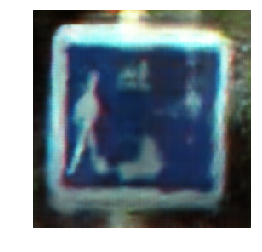

INFO:root:speed: 55.90348085237966 samples/s
INFO:root:discriminator loss = 0.481456, generator loss = 10.362667, binary training acc = 0.803796 at iter 0 epoch 49
INFO:root:speed: 29.12201475852837 samples/s
INFO:root:discriminator loss = 0.077876, generator loss = 13.840906, binary training acc = 0.849622 at iter 10 epoch 49
INFO:root:speed: 29.16277475440452 samples/s
INFO:root:discriminator loss = 0.367125, generator loss = 12.755832, binary training acc = 0.796906 at iter 20 epoch 49
INFO:root:speed: 29.125594153082304 samples/s
INFO:root:discriminator loss = 0.254358, generator loss = 14.938977, binary training acc = 0.753588 at iter 30 epoch 49
INFO:root:speed: 29.334510172266558 samples/s
INFO:root:discriminator loss = 0.372439, generator loss = 9.848012, binary training acc = 0.754374 at iter 40 epoch 49
INFO:root:speed: 29.055400767827184 samples/s
INFO:root:discriminator loss = 0.118959, generator loss = 11.404524, binary training acc = 0.770742 at iter 50 epoch 49
INFO:root

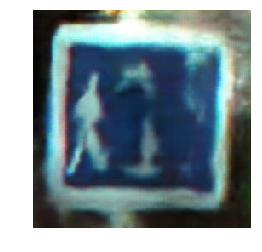

INFO:root:speed: 54.952781242466486 samples/s
INFO:root:discriminator loss = 0.195448, generator loss = 10.009149, binary training acc = 0.983388 at iter 0 epoch 50
INFO:root:speed: 29.495622038960374 samples/s
INFO:root:discriminator loss = 0.221177, generator loss = 13.327225, binary training acc = 0.894286 at iter 10 epoch 50
INFO:root:speed: 29.297913879876084 samples/s
INFO:root:discriminator loss = 0.302302, generator loss = 13.201665, binary training acc = 0.875992 at iter 20 epoch 50
INFO:root:speed: 28.843582699230826 samples/s
INFO:root:discriminator loss = 0.976809, generator loss = 16.235804, binary training acc = 0.836916 at iter 30 epoch 50
INFO:root:speed: 29.038563657624564 samples/s
INFO:root:discriminator loss = 0.573280, generator loss = 10.588385, binary training acc = 0.794863 at iter 40 epoch 50
INFO:root:speed: 29.166242486447093 samples/s
INFO:root:discriminator loss = 0.138174, generator loss = 11.361395, binary training acc = 0.813589 at iter 50 epoch 50
INFO:

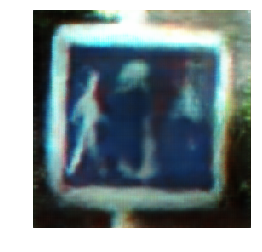

INFO:root:speed: 55.94023870906649 samples/s
INFO:root:discriminator loss = 0.246269, generator loss = 9.524757, binary training acc = 0.976082 at iter 0 epoch 51
INFO:root:speed: 29.43042846447309 samples/s
INFO:root:discriminator loss = 0.453837, generator loss = 13.755160, binary training acc = 0.822686 at iter 10 epoch 51
INFO:root:speed: 28.896560704214775 samples/s
INFO:root:discriminator loss = 0.337089, generator loss = 13.172424, binary training acc = 0.763545 at iter 20 epoch 51
INFO:root:speed: 28.557838367813822 samples/s
INFO:root:discriminator loss = 0.377705, generator loss = 15.675901, binary training acc = 0.763922 at iter 30 epoch 51
INFO:root:speed: 28.86804049491955 samples/s
INFO:root:discriminator loss = 0.326054, generator loss = 10.001780, binary training acc = 0.760528 at iter 40 epoch 51
INFO:root:speed: 29.30233500467029 samples/s
INFO:root:discriminator loss = 0.193612, generator loss = 12.142775, binary training acc = 0.781401 at iter 50 epoch 51
INFO:root:

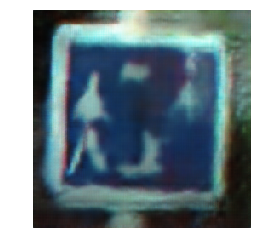

INFO:root:speed: 59.36105862788805 samples/s
INFO:root:discriminator loss = 0.099952, generator loss = 9.966959, binary training acc = 0.997102 at iter 0 epoch 52
INFO:root:speed: 29.594916309046187 samples/s
INFO:root:discriminator loss = 0.188523, generator loss = 13.370234, binary training acc = 0.888683 at iter 10 epoch 52
INFO:root:speed: 28.91291460210055 samples/s
INFO:root:discriminator loss = 0.517920, generator loss = 14.114935, binary training acc = 0.852354 at iter 20 epoch 52
INFO:root:speed: 29.335966897663084 samples/s
INFO:root:discriminator loss = 0.564554, generator loss = 15.578250, binary training acc = 0.783009 at iter 30 epoch 52
INFO:root:speed: 28.94801536880508 samples/s
INFO:root:discriminator loss = 0.468978, generator loss = 10.297373, binary training acc = 0.763776 at iter 40 epoch 52
INFO:root:speed: 29.652223154629308 samples/s
INFO:root:discriminator loss = 0.215092, generator loss = 11.543864, binary training acc = 0.768976 at iter 50 epoch 52
INFO:root

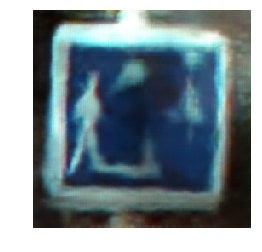

INFO:root:speed: 56.594891446613865 samples/s
INFO:root:discriminator loss = 0.129179, generator loss = 9.357481, binary training acc = 0.990286 at iter 0 epoch 53
INFO:root:speed: 29.256551032380067 samples/s
INFO:root:discriminator loss = 0.537568, generator loss = 13.478371, binary training acc = 0.885195 at iter 10 epoch 53
INFO:root:speed: 29.60325061633679 samples/s
INFO:root:discriminator loss = 0.288831, generator loss = 13.612224, binary training acc = 0.880735 at iter 20 epoch 53
INFO:root:speed: 29.309358329501638 samples/s
INFO:root:discriminator loss = 1.027765, generator loss = 16.387196, binary training acc = 0.808225 at iter 30 epoch 53
INFO:root:speed: 28.970929634201177 samples/s
INFO:root:discriminator loss = 0.340251, generator loss = 9.841255, binary training acc = 0.777213 at iter 40 epoch 53
INFO:root:speed: 29.428693913950113 samples/s
INFO:root:discriminator loss = 0.282961, generator loss = 11.546518, binary training acc = 0.781585 at iter 50 epoch 53
INFO:roo

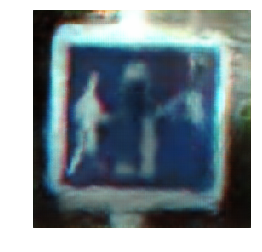

INFO:root:speed: 57.502378621742935 samples/s
INFO:root:discriminator loss = 0.205909, generator loss = 9.447314, binary training acc = 0.980531 at iter 0 epoch 54
INFO:root:speed: 29.158699702455436 samples/s
INFO:root:discriminator loss = 0.502881, generator loss = 13.462710, binary training acc = 0.819377 at iter 10 epoch 54
INFO:root:speed: 29.35773240903542 samples/s
INFO:root:discriminator loss = 0.155100, generator loss = 12.225540, binary training acc = 0.800418 at iter 20 epoch 54
INFO:root:speed: 29.094440478989913 samples/s
INFO:root:discriminator loss = 0.351081, generator loss = 15.674215, binary training acc = 0.769090 at iter 30 epoch 54
INFO:root:speed: 29.426835693834352 samples/s
INFO:root:discriminator loss = 0.592441, generator loss = 9.927261, binary training acc = 0.752549 at iter 40 epoch 54
INFO:root:speed: 28.804738084053742 samples/s
INFO:root:discriminator loss = 0.172259, generator loss = 10.826620, binary training acc = 0.766280 at iter 50 epoch 54
INFO:roo

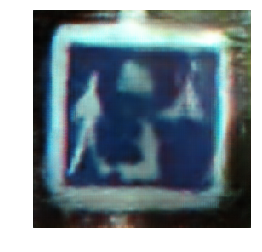

INFO:root:speed: 60.47621931349903 samples/s
INFO:root:discriminator loss = 0.625970, generator loss = 10.627585, binary training acc = 0.727469 at iter 0 epoch 55
INFO:root:speed: 29.18276101510241 samples/s
INFO:root:discriminator loss = 0.243129, generator loss = 12.889743, binary training acc = 0.807573 at iter 10 epoch 55
INFO:root:speed: 29.585939726367528 samples/s
INFO:root:discriminator loss = 0.157005, generator loss = 12.458761, binary training acc = 0.805547 at iter 20 epoch 55
INFO:root:speed: 29.620811879104433 samples/s
INFO:root:discriminator loss = 0.402015, generator loss = 15.026876, binary training acc = 0.798785 at iter 30 epoch 55
INFO:root:speed: 29.388711460766743 samples/s
INFO:root:discriminator loss = 0.608442, generator loss = 10.446544, binary training acc = 0.774827 at iter 40 epoch 55
INFO:root:speed: 29.54952568487722 samples/s
INFO:root:discriminator loss = 0.142348, generator loss = 11.163110, binary training acc = 0.786106 at iter 50 epoch 55
INFO:roo

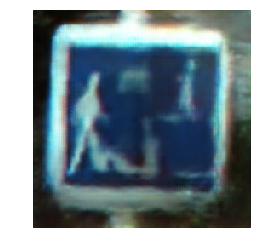

INFO:root:speed: 58.81162574175239 samples/s
INFO:root:discriminator loss = 0.532394, generator loss = 9.454718, binary training acc = 0.760898 at iter 0 epoch 56
INFO:root:speed: 29.071733496540965 samples/s
INFO:root:discriminator loss = 0.912535, generator loss = 13.300653, binary training acc = 0.838809 at iter 10 epoch 56
INFO:root:speed: 28.756255266284604 samples/s
INFO:root:discriminator loss = 0.107152, generator loss = 11.865540, binary training acc = 0.858727 at iter 20 epoch 56
INFO:root:speed: 29.089759052438918 samples/s
INFO:root:discriminator loss = 0.230368, generator loss = 15.054007, binary training acc = 0.831057 at iter 30 epoch 56
INFO:root:speed: 29.20086357000285 samples/s
INFO:root:discriminator loss = 0.444552, generator loss = 9.900198, binary training acc = 0.817690 at iter 40 epoch 56
INFO:root:speed: 29.216586908518448 samples/s
INFO:root:discriminator loss = 0.419893, generator loss = 11.497144, binary training acc = 0.816060 at iter 50 epoch 56
INFO:root

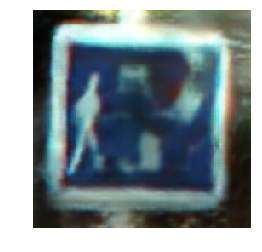

INFO:root:speed: 59.1654523628495 samples/s
INFO:root:discriminator loss = 0.270586, generator loss = 9.561458, binary training acc = 0.951020 at iter 0 epoch 57
INFO:root:speed: 28.919712588954077 samples/s
INFO:root:discriminator loss = 0.097501, generator loss = 12.821928, binary training acc = 0.951213 at iter 10 epoch 57
INFO:root:speed: 29.498754446646572 samples/s
INFO:root:discriminator loss = 0.446686, generator loss = 12.984830, binary training acc = 0.852702 at iter 20 epoch 57
INFO:root:speed: 28.854138934235355 samples/s
INFO:root:discriminator loss = 0.444509, generator loss = 14.883286, binary training acc = 0.826596 at iter 30 epoch 57
INFO:root:speed: 29.057111721831227 samples/s
INFO:root:discriminator loss = 0.416185, generator loss = 9.899315, binary training acc = 0.799354 at iter 40 epoch 57
INFO:root:speed: 29.263838266567685 samples/s
INFO:root:discriminator loss = 0.218251, generator loss = 10.905744, binary training acc = 0.814626 at iter 50 epoch 57
INFO:root

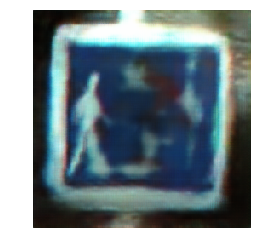

INFO:root:speed: 60.610716365585894 samples/s
INFO:root:discriminator loss = 0.070251, generator loss = 9.746701, binary training acc = 0.993184 at iter 0 epoch 58
INFO:root:speed: 28.845506850483268 samples/s
INFO:root:discriminator loss = 0.206175, generator loss = 12.614460, binary training acc = 0.880694 at iter 10 epoch 58
INFO:root:speed: 28.505880865743904 samples/s
INFO:root:discriminator loss = 0.263420, generator loss = 12.390100, binary training acc = 0.833726 at iter 20 epoch 58
INFO:root:speed: 28.874161426117727 samples/s
INFO:root:discriminator loss = 0.220741, generator loss = 14.445955, binary training acc = 0.824524 at iter 30 epoch 58
INFO:root:speed: 28.70188471629347 samples/s
INFO:root:discriminator loss = 1.183505, generator loss = 10.463837, binary training acc = 0.805896 at iter 40 epoch 58
INFO:root:speed: 29.366221490959376 samples/s
INFO:root:discriminator loss = 0.202849, generator loss = 10.447522, binary training acc = 0.808190 at iter 50 epoch 58
INFO:ro

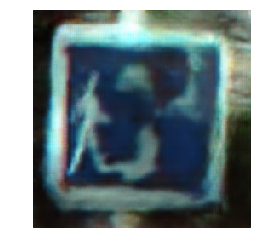

INFO:root:speed: 58.74375350140056 samples/s
INFO:root:discriminator loss = 0.209429, generator loss = 9.213366, binary training acc = 0.969673 at iter 0 epoch 59
INFO:root:speed: 29.133119817073382 samples/s
INFO:root:discriminator loss = 1.484383, generator loss = 13.744720, binary training acc = 0.903863 at iter 10 epoch 59
INFO:root:speed: 29.464438003419705 samples/s
INFO:root:discriminator loss = 0.476724, generator loss = 11.919574, binary training acc = 0.866552 at iter 20 epoch 59
INFO:root:speed: 29.00938137171092 samples/s
INFO:root:discriminator loss = 0.424938, generator loss = 14.669180, binary training acc = 0.835670 at iter 30 epoch 59
INFO:root:speed: 29.40090705808957 samples/s
INFO:root:discriminator loss = 0.372807, generator loss = 9.446653, binary training acc = 0.813121 at iter 40 epoch 59
INFO:root:speed: 29.171902135848864 samples/s
INFO:root:discriminator loss = 0.202805, generator loss = 11.062262, binary training acc = 0.822161 at iter 50 epoch 59
INFO:root:

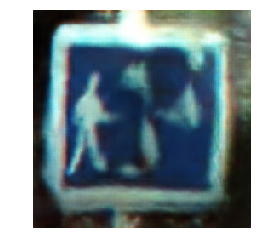

INFO:root:speed: 56.310115485099175 samples/s
INFO:root:discriminator loss = 0.565955, generator loss = 9.944860, binary training acc = 0.818041 at iter 0 epoch 60
INFO:root:speed: 28.56738867767233 samples/s
INFO:root:discriminator loss = 1.045463, generator loss = 12.726405, binary training acc = 0.912267 at iter 10 epoch 60
INFO:root:speed: 29.15079613296915 samples/s
INFO:root:discriminator loss = 0.344443, generator loss = 11.978074, binary training acc = 0.853153 at iter 20 epoch 60
INFO:root:speed: 29.065548664287448 samples/s
INFO:root:discriminator loss = 0.392479, generator loss = 14.547360, binary training acc = 0.794145 at iter 30 epoch 60
INFO:root:speed: 29.184121481755678 samples/s
INFO:root:discriminator loss = 0.484046, generator loss = 9.429595, binary training acc = 0.764404 at iter 40 epoch 60
INFO:root:speed: 29.155193231258163 samples/s
INFO:root:discriminator loss = 0.170986, generator loss = 10.363451, binary training acc = 0.775307 at iter 50 epoch 60
INFO:root

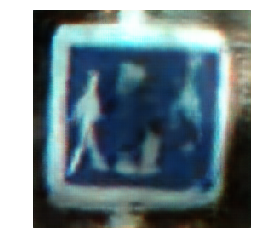

INFO:root:speed: 58.16616511115117 samples/s
INFO:root:discriminator loss = 0.340632, generator loss = 9.324353, binary training acc = 0.902204 at iter 0 epoch 61
INFO:root:speed: 29.0318101620583 samples/s
INFO:root:discriminator loss = 0.859062, generator loss = 12.600767, binary training acc = 0.850724 at iter 10 epoch 61
INFO:root:speed: 29.74445310411293 samples/s
INFO:root:discriminator loss = 0.254482, generator loss = 11.905110, binary training acc = 0.799149 at iter 20 epoch 61
INFO:root:speed: 29.33693128843024 samples/s
INFO:root:discriminator loss = 0.524809, generator loss = 15.037854, binary training acc = 0.759791 at iter 30 epoch 61
INFO:root:speed: 29.739918657220166 samples/s
INFO:root:discriminator loss = 0.826000, generator loss = 10.220613, binary training acc = 0.743309 at iter 40 epoch 61
INFO:root:speed: 28.98234029600751 samples/s
INFO:root:discriminator loss = 0.160070, generator loss = 10.916197, binary training acc = 0.752932 at iter 50 epoch 61
INFO:root:sp

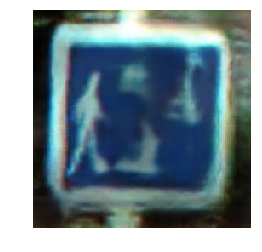

INFO:root:speed: 62.05665773514055 samples/s
INFO:root:discriminator loss = 0.203128, generator loss = 8.974241, binary training acc = 0.976857 at iter 0 epoch 62
INFO:root:speed: 29.287971225292246 samples/s
INFO:root:discriminator loss = 0.310364, generator loss = 13.236227, binary training acc = 0.918167 at iter 10 epoch 62
INFO:root:speed: 29.339250189565107 samples/s
INFO:root:discriminator loss = 0.683904, generator loss = 12.597274, binary training acc = 0.866430 at iter 20 epoch 62
INFO:root:speed: 28.774246926064325 samples/s
INFO:root:discriminator loss = 0.259966, generator loss = 14.488859, binary training acc = 0.831242 at iter 30 epoch 62
INFO:root:speed: 29.183654441591695 samples/s
INFO:root:discriminator loss = 0.685556, generator loss = 10.438151, binary training acc = 0.806074 at iter 40 epoch 62
INFO:root:speed: 29.47642724368998 samples/s
INFO:root:discriminator loss = 0.422133, generator loss = 10.695518, binary training acc = 0.809419 at iter 50 epoch 62
INFO:roo

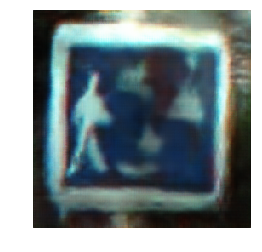

INFO:root:speed: 58.350744078051335 samples/s
INFO:root:discriminator loss = 0.202208, generator loss = 9.541525, binary training acc = 0.975796 at iter 0 epoch 63
INFO:root:speed: 29.465824860356584 samples/s
INFO:root:discriminator loss = 0.083372, generator loss = 12.579829, binary training acc = 0.847896 at iter 10 epoch 63
INFO:root:speed: 28.709723567441397 samples/s
INFO:root:discriminator loss = 0.146184, generator loss = 11.134041, binary training acc = 0.854659 at iter 20 epoch 63
INFO:root:speed: 29.005589775613696 samples/s
INFO:root:discriminator loss = 0.600182, generator loss = 15.447739, binary training acc = 0.813273 at iter 30 epoch 63
INFO:root:speed: 29.021103469271964 samples/s
INFO:root:discriminator loss = 0.680029, generator loss = 10.427748, binary training acc = 0.778391 at iter 40 epoch 63
INFO:root:speed: 29.290323301507847 samples/s
INFO:root:discriminator loss = 0.170763, generator loss = 11.004351, binary training acc = 0.793394 at iter 50 epoch 63
INFO:r

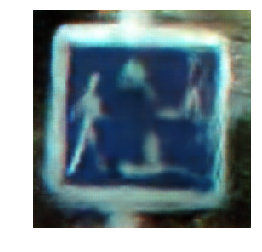

INFO:root:speed: 56.47236232325055 samples/s
INFO:root:discriminator loss = 0.095678, generator loss = 9.037725, binary training acc = 0.996531 at iter 0 epoch 64
INFO:root:speed: 29.04453588201322 samples/s
INFO:root:discriminator loss = 0.235791, generator loss = 13.152555, binary training acc = 0.823224 at iter 10 epoch 64
INFO:root:speed: 29.00422584591256 samples/s
INFO:root:discriminator loss = 0.509052, generator loss = 12.925075, binary training acc = 0.783207 at iter 20 epoch 64
INFO:root:speed: 28.874837272413725 samples/s
INFO:root:discriminator loss = 0.335907, generator loss = 14.776396, binary training acc = 0.758192 at iter 30 epoch 64
INFO:root:speed: 29.233019906146087 samples/s
INFO:root:discriminator loss = 0.497577, generator loss = 10.452806, binary training acc = 0.756062 at iter 40 epoch 64
INFO:root:speed: 29.374982928867126 samples/s
INFO:root:discriminator loss = 0.173538, generator loss = 11.399747, binary training acc = 0.769033 at iter 50 epoch 64
INFO:root

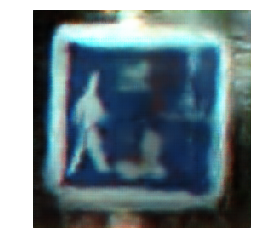

INFO:root:speed: 57.329466084574655 samples/s
INFO:root:discriminator loss = 0.259144, generator loss = 8.806740, binary training acc = 0.946490 at iter 0 epoch 65
INFO:root:speed: 29.26792233746804 samples/s
INFO:root:discriminator loss = 0.802415, generator loss = 12.857699, binary training acc = 0.864442 at iter 10 epoch 65
INFO:root:speed: 29.434476544303255 samples/s
INFO:root:discriminator loss = 0.356490, generator loss = 11.887491, binary training acc = 0.893320 at iter 20 epoch 65
INFO:root:speed: 29.79323826328097 samples/s
INFO:root:discriminator loss = 0.618771, generator loss = 15.755934, binary training acc = 0.826736 at iter 30 epoch 65
INFO:root:speed: 29.221390681323214 samples/s
INFO:root:discriminator loss = 0.473110, generator loss = 10.231974, binary training acc = 0.793887 at iter 40 epoch 65
INFO:root:speed: 29.513803423043445 samples/s
INFO:root:discriminator loss = 0.278840, generator loss = 10.776196, binary training acc = 0.802266 at iter 50 epoch 65
INFO:roo

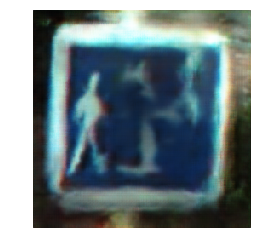

INFO:root:speed: 57.62118943275954 samples/s
INFO:root:discriminator loss = 0.250829, generator loss = 8.555017, binary training acc = 0.961061 at iter 0 epoch 66
INFO:root:speed: 28.903669686837585 samples/s
INFO:root:discriminator loss = 0.162452, generator loss = 12.396505, binary training acc = 0.936245 at iter 10 epoch 66
INFO:root:speed: 28.872571324331673 samples/s
INFO:root:discriminator loss = 0.533608, generator loss = 11.789177, binary training acc = 0.848128 at iter 20 epoch 66
INFO:root:speed: 29.270414180536655 samples/s
INFO:root:discriminator loss = 0.389307, generator loss = 14.503531, binary training acc = 0.800533 at iter 30 epoch 66
INFO:root:speed: 29.187533358988293 samples/s
INFO:root:discriminator loss = 0.456711, generator loss = 9.956636, binary training acc = 0.784540 at iter 40 epoch 66
INFO:root:speed: 29.57882495809265 samples/s
INFO:root:discriminator loss = 0.389735, generator loss = 10.926448, binary training acc = 0.802513 at iter 50 epoch 66
INFO:root

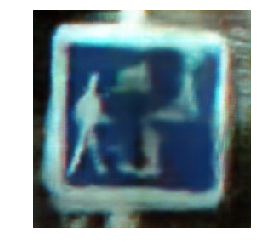

INFO:root:speed: 56.44318007487532 samples/s
INFO:root:discriminator loss = 0.345468, generator loss = 8.862870, binary training acc = 0.912531 at iter 0 epoch 67
INFO:root:speed: 29.29580612806522 samples/s
INFO:root:discriminator loss = 0.636478, generator loss = 12.048376, binary training acc = 0.838497 at iter 10 epoch 67
INFO:root:speed: 29.871045346714745 samples/s
INFO:root:discriminator loss = 0.216156, generator loss = 10.921691, binary training acc = 0.851761 at iter 20 epoch 67
INFO:root:speed: 29.672235408140526 samples/s
INFO:root:discriminator loss = 0.724627, generator loss = 14.781764, binary training acc = 0.805392 at iter 30 epoch 67
INFO:root:speed: 29.458250486545634 samples/s
INFO:root:discriminator loss = 0.621943, generator loss = 9.901508, binary training acc = 0.760302 at iter 40 epoch 67
INFO:root:speed: 29.45045253793384 samples/s
INFO:root:discriminator loss = 0.196858, generator loss = 10.076385, binary training acc = 0.776843 at iter 50 epoch 67
INFO:root:

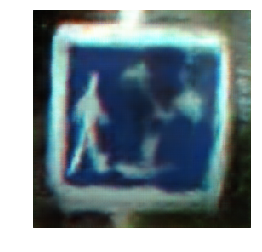

INFO:root:speed: 60.34926367436206 samples/s
INFO:root:discriminator loss = 0.199384, generator loss = 8.982841, binary training acc = 0.978898 at iter 0 epoch 68
INFO:root:speed: 29.18674124496019 samples/s
INFO:root:discriminator loss = 0.406196, generator loss = 12.598837, binary training acc = 0.924660 at iter 10 epoch 68
INFO:root:speed: 29.223426654794203 samples/s
INFO:root:discriminator loss = 0.327900, generator loss = 11.686017, binary training acc = 0.899635 at iter 20 epoch 68
INFO:root:speed: 29.354712055625736 samples/s
INFO:root:discriminator loss = 0.486554, generator loss = 15.240354, binary training acc = 0.843127 at iter 30 epoch 68
INFO:root:speed: 28.955909297390292 samples/s
INFO:root:discriminator loss = 0.525589, generator loss = 9.698604, binary training acc = 0.802021 at iter 40 epoch 68
INFO:root:speed: 29.03574931932925 samples/s
INFO:root:discriminator loss = 0.202608, generator loss = 10.356424, binary training acc = 0.808463 at iter 50 epoch 68
INFO:root:

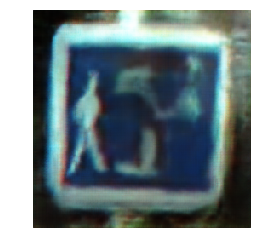

INFO:root:speed: 57.99662056587546 samples/s
INFO:root:discriminator loss = 0.144750, generator loss = 8.787858, binary training acc = 0.993633 at iter 0 epoch 69
INFO:root:speed: 28.68957516650581 samples/s
INFO:root:discriminator loss = 0.475254, generator loss = 13.129521, binary training acc = 0.891121 at iter 10 epoch 69
INFO:root:speed: 29.375826441650418 samples/s
INFO:root:discriminator loss = 0.295367, generator loss = 11.838165, binary training acc = 0.828163 at iter 20 epoch 69
INFO:root:speed: 28.890470073254143 samples/s
INFO:root:discriminator loss = 0.480895, generator loss = 15.359362, binary training acc = 0.776078 at iter 30 epoch 69
INFO:root:speed: 29.090485381946202 samples/s
INFO:root:discriminator loss = 0.764299, generator loss = 10.349067, binary training acc = 0.749405 at iter 40 epoch 69
INFO:root:speed: 29.54590377919243 samples/s
INFO:root:discriminator loss = 0.177619, generator loss = 10.396364, binary training acc = 0.762374 at iter 50 epoch 69
INFO:root

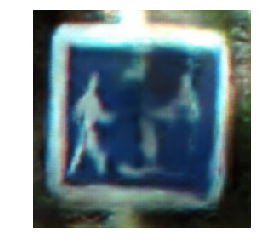

INFO:root:speed: 61.117135600555464 samples/s
INFO:root:discriminator loss = 0.641756, generator loss = 9.028552, binary training acc = 0.692000 at iter 0 epoch 70
INFO:root:speed: 29.578449493556892 samples/s
INFO:root:discriminator loss = 0.101752, generator loss = 11.917989, binary training acc = 0.820891 at iter 10 epoch 70
INFO:root:speed: 28.95696881034422 samples/s
INFO:root:discriminator loss = 0.191580, generator loss = 11.437178, binary training acc = 0.773679 at iter 20 epoch 70
INFO:root:speed: 29.41247337887238 samples/s
INFO:root:discriminator loss = 0.663619, generator loss = 14.914142, binary training acc = 0.735921 at iter 30 epoch 70
INFO:root:speed: 29.179228455268717 samples/s
INFO:root:discriminator loss = 0.542443, generator loss = 9.423630, binary training acc = 0.713484 at iter 40 epoch 70
INFO:root:speed: 29.254877726403716 samples/s
INFO:root:discriminator loss = 0.241462, generator loss = 10.306941, binary training acc = 0.743034 at iter 50 epoch 70
INFO:root

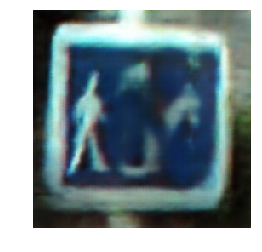

INFO:root:speed: 60.590928199031254 samples/s
INFO:root:discriminator loss = 0.138430, generator loss = 8.523114, binary training acc = 0.995714 at iter 0 epoch 71
INFO:root:speed: 29.971431307228492 samples/s
INFO:root:discriminator loss = 0.177870, generator loss = 11.871397, binary training acc = 0.871072 at iter 10 epoch 71
INFO:root:speed: 29.319848392278686 samples/s
INFO:root:discriminator loss = 0.615674, generator loss = 11.209355, binary training acc = 0.855357 at iter 20 epoch 71
INFO:root:speed: 29.730938207511727 samples/s
INFO:root:discriminator loss = 0.642674, generator loss = 15.053465, binary training acc = 0.780812 at iter 30 epoch 71
INFO:root:speed: 30.086472613180135 samples/s
INFO:root:discriminator loss = 0.756590, generator loss = 9.598715, binary training acc = 0.743351 at iter 40 epoch 71
INFO:root:speed: 29.88487958919463 samples/s
INFO:root:discriminator loss = 0.192521, generator loss = 10.226091, binary training acc = 0.758303 at iter 50 epoch 71
INFO:roo

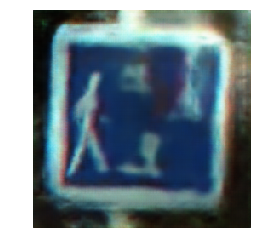

INFO:root:speed: 59.556271201362 samples/s
INFO:root:discriminator loss = 0.177474, generator loss = 8.215919, binary training acc = 0.984612 at iter 0 epoch 72
INFO:root:speed: 28.896162545323524 samples/s
INFO:root:discriminator loss = 0.853699, generator loss = 12.506597, binary training acc = 0.778987 at iter 10 epoch 72
INFO:root:speed: 29.18952398914067 samples/s
INFO:root:discriminator loss = 0.746347, generator loss = 11.347311, binary training acc = 0.776517 at iter 20 epoch 72
INFO:root:speed: 29.190986665961418 samples/s
INFO:root:discriminator loss = 0.403415, generator loss = 14.650592, binary training acc = 0.768987 at iter 30 epoch 72
INFO:root:speed: 29.482207926582394 samples/s
INFO:root:discriminator loss = 0.466054, generator loss = 9.156304, binary training acc = 0.751794 at iter 40 epoch 72
INFO:root:speed: 29.05463593591541 samples/s
INFO:root:discriminator loss = 0.165617, generator loss = 10.847489, binary training acc = 0.759819 at iter 50 epoch 72
INFO:root:sp

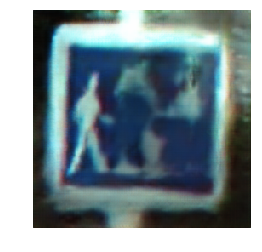

INFO:root:speed: 57.31873273832219 samples/s
INFO:root:discriminator loss = 0.517499, generator loss = 8.813519, binary training acc = 0.779061 at iter 0 epoch 73
INFO:root:speed: 29.345182498553488 samples/s
INFO:root:discriminator loss = 1.137368, generator loss = 13.070707, binary training acc = 0.848542 at iter 10 epoch 73
INFO:root:speed: 29.485689861707094 samples/s
INFO:root:discriminator loss = 0.563465, generator loss = 11.786349, binary training acc = 0.831102 at iter 20 epoch 73
INFO:root:speed: 29.079090224615182 samples/s
INFO:root:discriminator loss = 0.090049, generator loss = 13.929880, binary training acc = 0.823750 at iter 30 epoch 73
INFO:root:speed: 29.14004200475072 samples/s
INFO:root:discriminator loss = 0.464183, generator loss = 9.391541, binary training acc = 0.790812 at iter 40 epoch 73
INFO:root:speed: 29.17415443513777 samples/s
INFO:root:discriminator loss = 0.192786, generator loss = 10.086151, binary training acc = 0.790799 at iter 50 epoch 73
INFO:root:

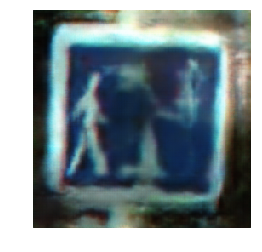

INFO:root:speed: 58.31375084287432 samples/s
INFO:root:discriminator loss = 0.255721, generator loss = 8.410903, binary training acc = 0.962408 at iter 0 epoch 74
INFO:root:speed: 28.95207171089234 samples/s
INFO:root:discriminator loss = 0.207860, generator loss = 12.142133, binary training acc = 0.876145 at iter 10 epoch 74
INFO:root:speed: 29.735048303544907 samples/s
INFO:root:discriminator loss = 0.516945, generator loss = 12.009551, binary training acc = 0.875996 at iter 20 epoch 74
INFO:root:speed: 29.34087158597812 samples/s
INFO:root:discriminator loss = 0.771724, generator loss = 14.916948, binary training acc = 0.795697 at iter 30 epoch 74
INFO:root:speed: 28.697446563945373 samples/s
INFO:root:discriminator loss = 0.363409, generator loss = 9.189198, binary training acc = 0.781779 at iter 40 epoch 74
INFO:root:speed: 29.101526019485647 samples/s
INFO:root:discriminator loss = 0.184272, generator loss = 9.888426, binary training acc = 0.796999 at iter 50 epoch 74
INFO:root:s

In [ ]:
from datetime import datetime
import time
import logging

def facc(label, pred):
        pred = pred.ravel()
        label = label.ravel()
        return ((pred > 0.5) == label).mean()

def train():
    image_pool = ImagePool(pool_size)
    metric = mx.metric.CustomMetric(facc)

    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)

    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        train_data.reset()
        iter = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x, y)) + log(1 - D(x, G(x, z)))
            ###########################
            real_in = batch.data[0].as_in_context(ctx)
            real_out = batch.data[1].as_in_context(ctx)

            fake_out = netG(real_in)
            fake_concat = image_pool.query(nd.concat(real_in, fake_out, dim=1))
            with autograd.record():
                # Train with fake image
                # Use image pooling to utilize history images
                output = netD(fake_concat)
                fake_label = nd.zeros(output.shape, ctx=ctx)
                errD_fake = GAN_loss(output, fake_label)
                metric.update([fake_label,], [output,])

                # Train with real image
                real_concat = nd.concat(real_in, real_out, dim=1)
                output = netD(real_concat)
                real_label = nd.ones(output.shape, ctx=ctx)
                errD_real = GAN_loss(output, real_label)
                errD = (errD_real + errD_fake) * 0.5
                errD.backward()
                metric.update([real_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(x, G(x, z))) - lambda1 * L1(y, G(x, z))
            ###########################
            with autograd.record():
                fake_out = netG(real_in)
                fake_concat = nd.concat(real_in, fake_out, dim=1)
                output = netD(fake_concat)
                real_label = nd.ones(output.shape, ctx=ctx)
                errG = GAN_loss(output, real_label) + L1_loss(real_out, fake_out) * lambda1
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            # Print log infomation every ten batches
            if iter % 10 == 0:
                name, acc = metric.get()
                logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
                logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                         %(nd.mean(errD).asscalar(),
                           nd.mean(errG).asscalar(), acc, iter, epoch))
            iter = iter + 1
            btic = time.time()

        name, acc = metric.get()
        metric.reset()
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))

        # Visualize one generated image for each epoch
        fake_img = fake_out[0]
        visualize(fake_img)
        plt.show()

train()

In [ ]:
def print_result():
    import random
    num_image = 4
    img_in_list, img_out_list = val_data.next().data
    for i in range(num_image):
        img_in = nd.expand_dims(img_in_list[i], axis=0)
        plt.subplot(2,4,i+1)
        visualize(img_in[0])
        img_out = netG(img_in.as_in_context(ctx))
        plt.subplot(2,4,i+5)
        visualize(img_out[0])
    plt.show()

In [ ]:
print_result()

In [ ]:
save_dir = os.path.join(os.getcwd(), 'model')

In [ ]:
os.makedirs(save_dir, exist_ok=True)

In [ ]:
filename = "{}/{}".format(save_dir, 'netg-100-0000.params')
netG.collect_params().save(filename)

In [ ]:
netG.hybridize()

In [ ]:
from mxnet import sym
x = sym.var('data')
y = netG(x)

In [ ]:
filename = "{}/{}".format(save_dir, 'netg-100-symbol.json')
y.save(filename)